# Dependencies loading

In [1]:
import pandas as pd # Standard
import numpy as np # Standard
from datetime import datetime # Date and Time
from pandas_datareader import data as pdr #import data from FRED

import seaborn as sns # Data Visualization
import matplotlib.pyplot as plt # Data Visualization
from matplotlib.ticker import FuncFormatter, LogLocator # Data Visualization
import plotly.express as px # Data Visualization

import statsmodels.api as sm # Statistics
import statsmodels.tsa.api as tsa # Statistics
from scipy.stats import norm, skew, kurtosis, shapiro # Statistics
from scipy.optimize import minimize # Statistics
from scipy.stats import binomtest #Statistics 
from statsmodels.tsa.stattools import adfuller # Statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Statistics

from arch import arch_model # TS
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data preparation

## Data loading

In [3]:
BTC_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/Bitcoin_daily.csv'
SP500_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/S&P500.csv'
TMUBMUSD01Y_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/TMUBMUSD01Y.csv'

df_BTC = pd.read_csv(BTC_url)
df_BTC.columns = df_BTC.columns.str.strip()

df_SP500 = pd.read_csv(SP500_url)
df_SP500.columns = df_SP500.columns.str.strip()

df_TMUBMUSD01Y = pd.read_csv(TMUBMUSD01Y_url)
df_TMUBMUSD01Y.columns = df_TMUBMUSD01Y.columns.str.strip()

start=datetime(2014, 5, 1)
end=datetime(2024, 5, 1)

# Macroeconomic Indicators (from FRED):

UN_Rate = pdr.get_data_fred('UNRATE', start, end) # Unemployment Rate
Real_GDP = pdr.get_data_fred('A191RL1Q225SBEA', start, end) # Real GDP
CPI = pdr.get_data_fred('CPIAUCSL', start, end) # Consumer Price Index
VIX = pdr.get_data_fred('VIXCLS', start, end) # Volatility Index
Ten_Year_Treasury_Yield = pdr.get_data_fred('DGS10', start, end) # 10-Year Treasury Yield
Federal_Funds_Rate = pdr.get_data_fred('FEDFUNDS', start, end) # Federal Funds Rate
BBB_Credit_Spread = pdr.get_data_fred('BAMLC0A4CBBB', start, end) # BBB Credit Spread

# print(df_BTC.head())
# print(df_SP500.head())
# print(df_TMUBMUSD01Y.head())
# print(UN_Rate.head())
# print(Real_GDP.head())
# print(CPI.head())
# print(VIX.head())
# print(Ten_Year_Treasury_Yield.head())
# print(Federal_Funds_Rate.head())
# print(BBB_Credit_Spread.head())

## Dataset adjustment

In [4]:
# Select Columns
df_SP500 = df_SP500[['Date', 'Close']].rename(columns={'Close': 'Price'})
df_BTC = df_BTC[['Date', 'Price']]
df_TMUBMUSD01Y = df_TMUBMUSD01Y[['Date', 'Close']].rename(columns={'Close': 'Price'})

########################################################################################

# Define Price as 'numeric'

df_SP500['Price'] = df_SP500['Price'].astype(str)
df_BTC['Price'] = df_BTC['Price'].astype(str)
df_TMUBMUSD01Y['Price'] = df_TMUBMUSD01Y['Price'].astype(str)

df_SP500['Price'] = pd.to_numeric(df_SP500['Price'].str.replace(',', ''), errors='coerce')
df_BTC['Price'] = pd.to_numeric(df_BTC['Price'].str.replace(',', ''), errors='coerce')
df_TMUBMUSD01Y['Price'] = pd.to_numeric(df_TMUBMUSD01Y['Price'].str.replace(',', ''), errors='coerce')

########################################################################################

# Date
df_SP500['Date'] = pd.to_datetime(df_SP500['Date'])
df_SP500.set_index('Date', inplace=True)

df_BTC['Date'] = pd.to_datetime(df_BTC['Date'])
df_BTC.set_index('Date', inplace=True)

df_TMUBMUSD01Y['Date'] = pd.to_datetime(df_TMUBMUSD01Y['Date'])
df_TMUBMUSD01Y.set_index('Date', inplace=True)

# Sort by Date
df_SP500.sort_index(inplace=True)
df_BTC.sort_index(inplace=True)
df_TMUBMUSD01Y.sort_index(inplace=True)

df_SP500 = df_SP500.loc[start:end]
df_BTC = df_BTC.loc[start:end] # Cryptocurrency market is open on weekends
df_TMUBMUSD01Y = df_TMUBMUSD01Y.loc[start:end]

########################################################################################

# print(df_SP500.head())
# print(df_SP500.tail()) 
# print(df_TMUBMUSD01Y.head())
# print(df_TMUBMUSD01Y.tail())
# print(df_BTC.tail())

## Returns calculation (Daily)

In [5]:
df_SP500['Return'] = df_SP500['Price'].pct_change() 
df_BTC['Return'] = df_BTC['Price'].pct_change() 
df_TMUBMUSD01Y['Return'] = df_TMUBMUSD01Y['Price'].pct_change() 

In [6]:
# print(df_SP500.head())
# print(df_TMUBMUSD01Y.head())
# print(df_BTC.head())

# Exploratory Data Analysis

## Summary Statistics

In [7]:
print(df_SP500.describe())
print(df_BTC.describe())
print(df_TMUBMUSD01Y.describe())

             Price       Return
count  2517.000000  2516.000000
mean   3110.347695     0.000454
std     944.565837     0.011169
min    1829.079956    -0.119841
25%    2180.389893    -0.003781
50%    2859.530029     0.000596
75%    3992.929932     0.005679
max    5254.350098     0.093828
              Price       Return
count   3654.000000  3653.000000
mean   15441.343240     0.002015
std    17693.556835     0.036929
min      164.900000    -0.391816
25%      704.375000    -0.012352
50%     8186.000000     0.001205
75%    26251.075000     0.017021
max    73066.300000     0.272286
             Price       Return
count  2536.000000  2535.000000
mean      1.658946     0.013124
std       1.700777     0.389819
min       0.005000    -0.934211
25%       0.214000    -0.011437
50%       1.068000     0.000000
75%       2.450500     0.012862
max       5.515000    14.200000


## Check for Missing Values

In [8]:
print(df_SP500.isnull().sum())
print(df_BTC.isnull().sum())
print(df_TMUBMUSD01Y.isnull().sum())

Price     0
Return    1
dtype: int64
Price     0
Return    1
dtype: int64
Price     0
Return    1
dtype: int64


## Price Changes of the S&P 500 Index, Bitcoin, and the 1-Year U.S. Treasury Bond

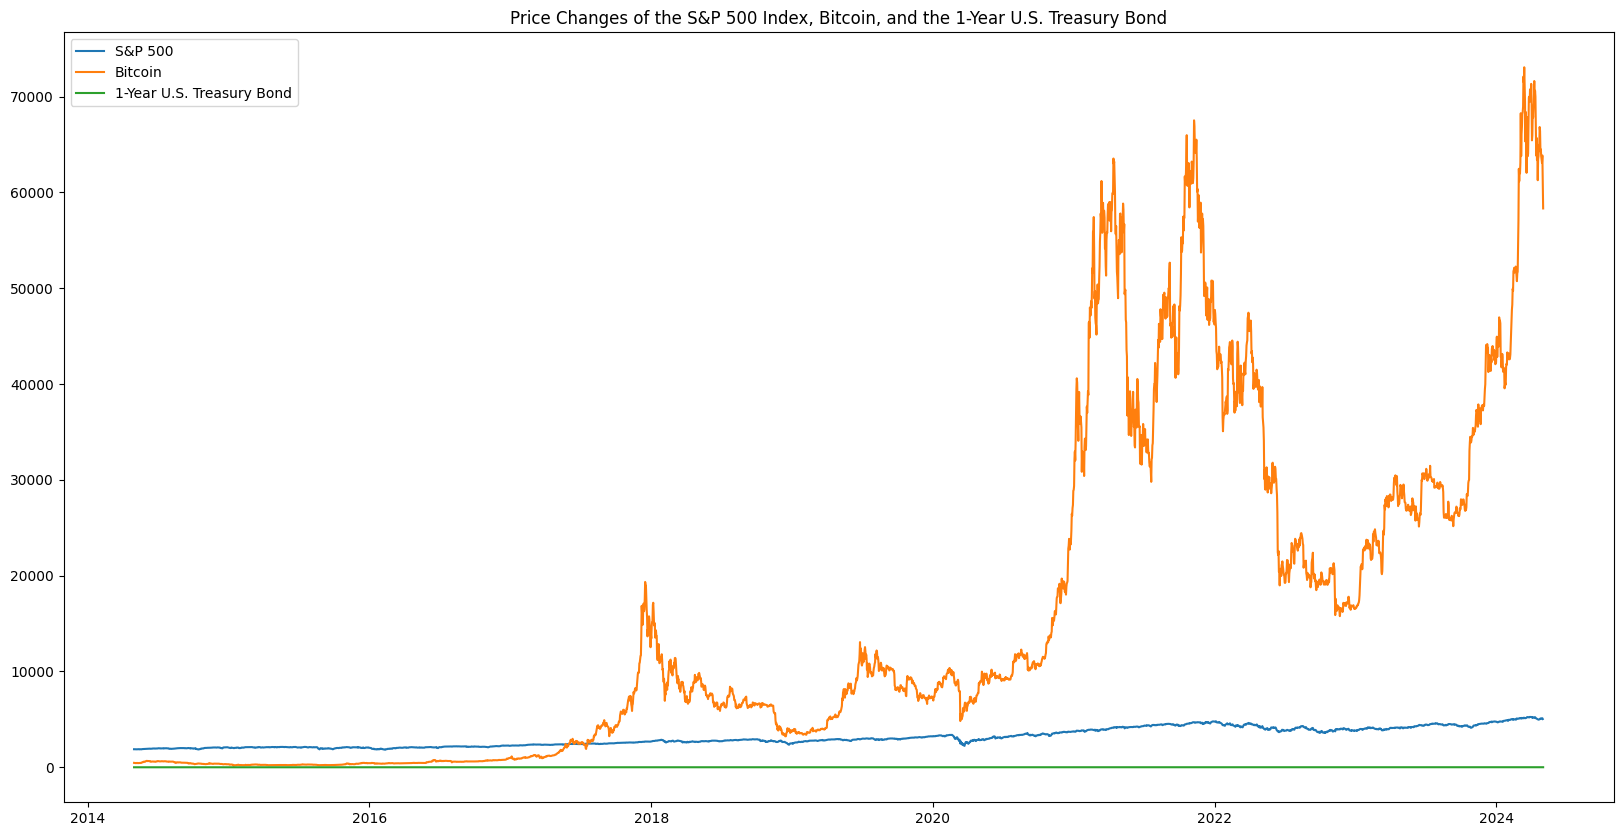

In [9]:
plt.figure(figsize=(20, 10))

plt.plot(df_SP500.index, df_SP500['Price'], label='S&P 500')
plt.plot(df_BTC.index, df_BTC['Price'], label='Bitcoin')
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Price'], label='1-Year U.S. Treasury Bond')

plt.xlabel('')
plt.ylabel('')
plt.title('Price Changes of the S&P 500 Index, Bitcoin, and the 1-Year U.S. Treasury Bond')
plt.legend()
plt.show()

### S&P 500 Index

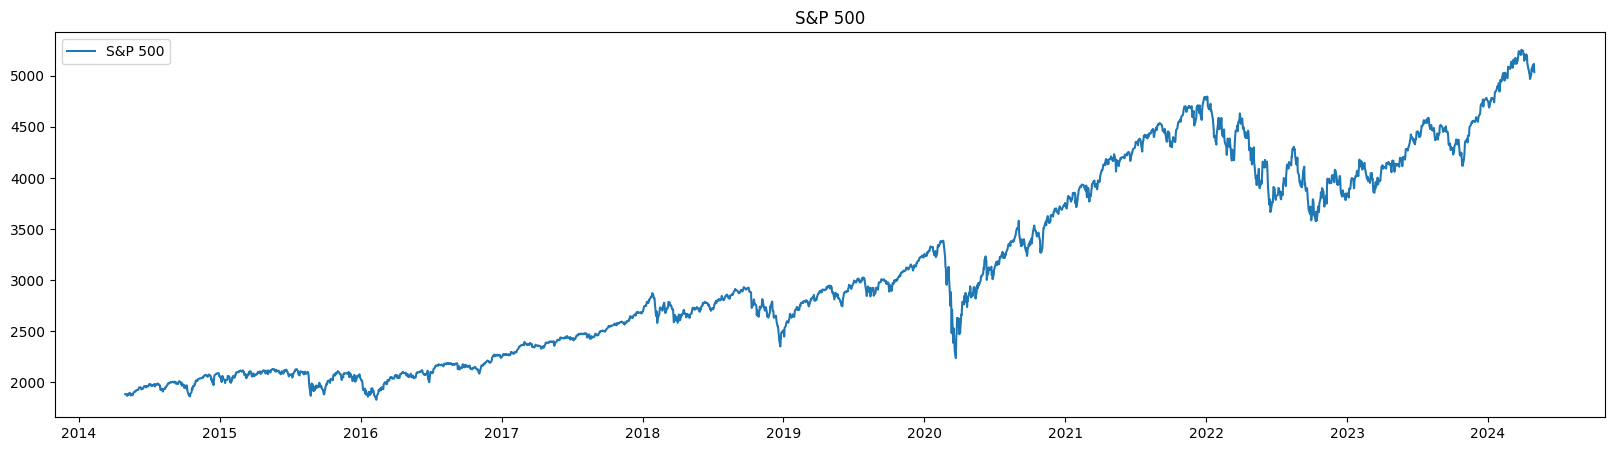

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(df_SP500.index, df_SP500['Price'], label='S&P 500')
plt.xlabel('')
plt.ylabel('')
plt.title('S&P 500')
plt.legend()
plt.grid(False)
plt.show()

### Bitcoin

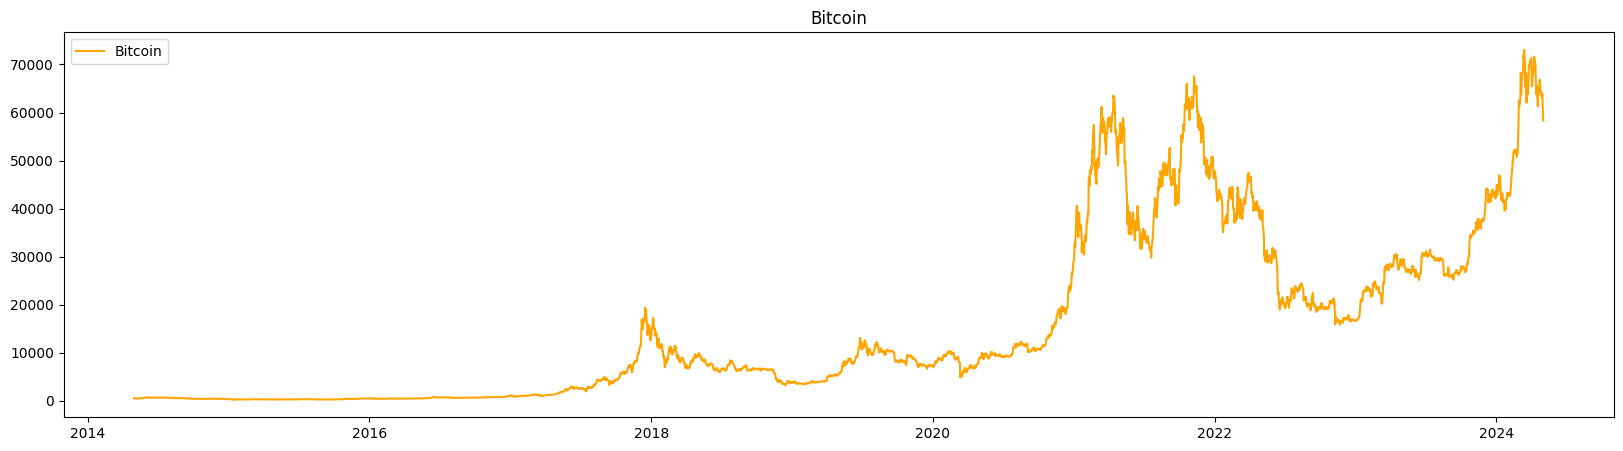

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(df_BTC.index, df_BTC['Price'], label='Bitcoin', color='orange')
plt.xlabel('')
plt.ylabel('')
plt.title('Bitcoin')
plt.legend()
plt.grid(False)
plt.show()

### 1-Year U.S. Treasury Bond

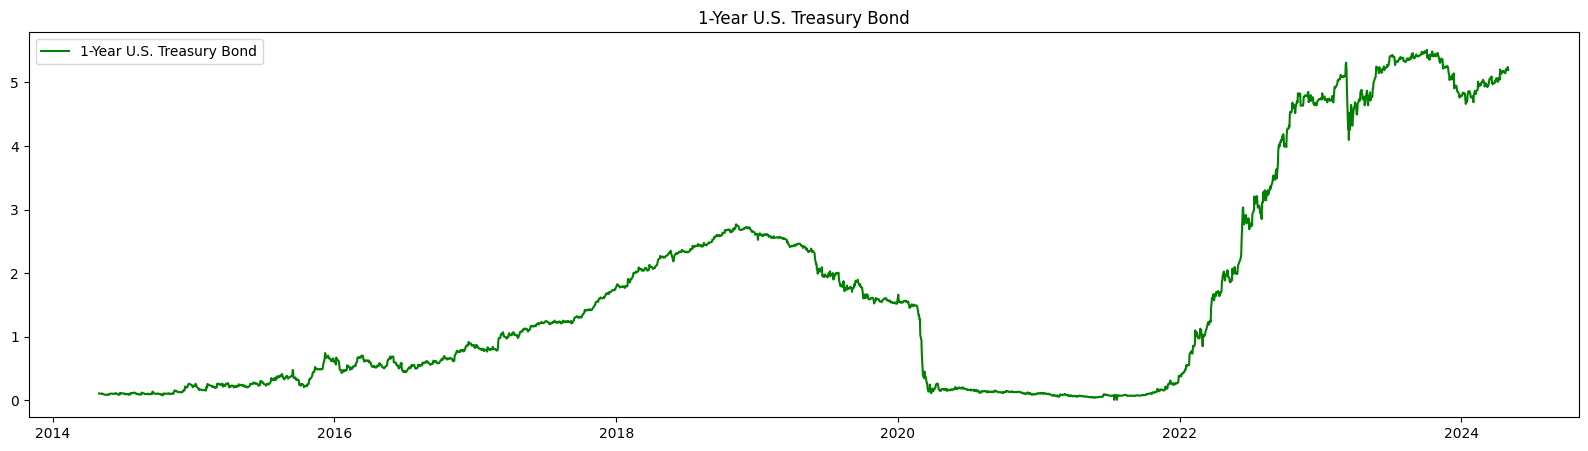

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Price'], label='1-Year U.S. Treasury Bond', color='green')
plt.xlabel('')
plt.ylabel('')
plt.title('1-Year U.S. Treasury Bond')
plt.legend()
plt.grid(False)
plt.show()

## Daily Returns

In [13]:
df_combined_returns = pd.concat([df_SP500[['Return']], df_BTC[['Return']], df_TMUBMUSD01Y[['Return']]], axis=1, join='inner')
df_combined_returns.columns = ['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return']

In [14]:
df_combined_returns

,SP500_Return,BTC_Return,TMUBMUSD01Y_Return
Date,,,
2014-05-01,NaN,NaN,NaN
2014-05-02,-0.001348,-0.013910,0.000000
2014-05-05,0.001871,-0.011697,-0.019231
2014-05-06,-0.008988,0.003017,0.000000
2014-05-07,0.005616,0.033087,-0.029412
...,...,...,...
2024-04-24,0.000213,-0.032061,0.001944
2024-04-25,-0.004576,0.003288,0.010475
2024-04-26,0.010209,-0.011329,-0.002496


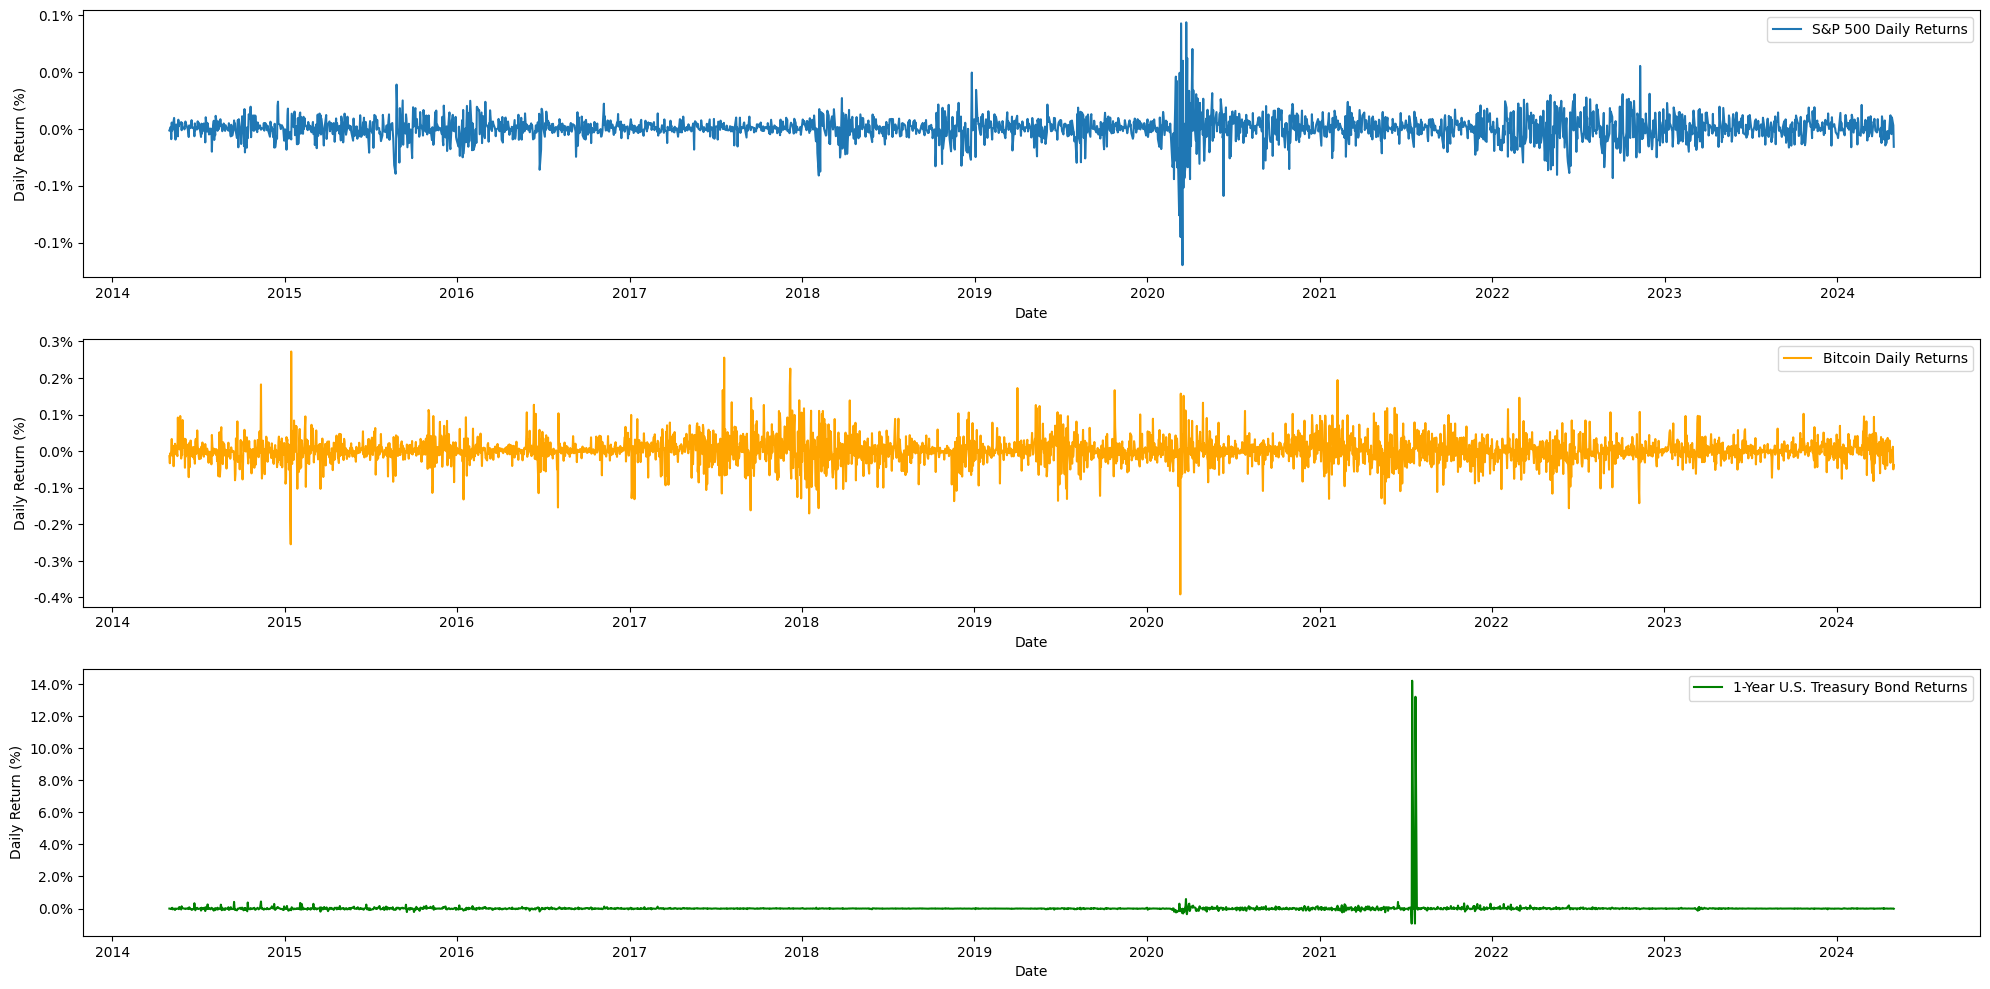

In [15]:
def percentage_formatter(x, pos):
    return f'{x:.1f}%'

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(df_SP500.index, df_SP500['Return'], label='S&P 500 Daily Returns')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_BTC.index, df_BTC['Return'], label='Bitcoin Daily Returns', color='orange')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Return'], label='1-Year U.S. Treasury Bond Returns', color='green')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.tight_layout()
plt.show()

## Forward-filling

In [16]:
""" Forward-filling missing values ensures consistency gaps 
by filling gaps with the last available observation, which is essential 
when aligning datasets with different trading schedules
, such as traditional markets and Bitcoin (Open on Weekends)."""

# This piece of code was taken from ChapGPT 
# Recommended using Forward-filling for Bitcoin

df_SP500 = df_SP500.asfreq('D').fillna(method='ffill')
df_TMUBMUSD01Y = df_TMUBMUSD01Y.asfreq('D').fillna(method='ffill')

# Linear Interpolation
df_SP500['Price'] = df_SP500['Price'].interpolate(method='linear')
df_TMUBMUSD01Y['Price'] = df_TMUBMUSD01Y['Price'].interpolate(method='linear')

## Merging Files

In [17]:
# Merge files & Rename Columns
df_assets = pd.merge(df_SP500, df_BTC, on='Date', how='outer')
df_assets = pd.merge(df_assets, df_TMUBMUSD01Y, on='Date', how='outer')

df_assets.columns = ['SP500_Price', 'SP500_Return', 'BTC_Price', 'BTC_Return', 'TMUBMUSD01Y_Price', 'TMUBMUSD01Y_Return']

# Drop NaN
df_assets.dropna(subset=['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return'], inplace=True)

# print(df_assets.head())

## cVAR method 

In [18]:
def calculate_cvar(returns, confidence_level=0.95):
    # Calculate the VaR at the specified confidence level
    var_threshold = np.percentile(returns.dropna(), (1 - confidence_level) * 100)
    
    # Calculate CVaR as the average of the returns below the VaR threshold
    cvar = returns[returns <= var_threshold].mean()
    
    return var_threshold, cvar

# Calculate CVaR for SP500, BTC, and TMUBMUSD01Y
var_sp500, cvar_sp500 = calculate_cvar(df_SP500['Return'])
var_btc, cvar_btc = calculate_cvar(df_BTC['Return'])
var_tmubmusd01y, cvar_tmubmusd01y = calculate_cvar(df_TMUBMUSD01Y['Return'])

print(f"SP500 VaR: {var_sp500}, CVaR: {cvar_sp500}")
print(f"BTC VaR: {var_btc}, CVaR: {cvar_btc}")
print(f"TMUBMUSD01Y VaR: {var_tmubmusd01y}, CVaR: {cvar_tmubmusd01y}")

SP500 VaR: -0.017232619078902833, CVaR: -0.0266728847260834
BTC VaR: -0.05730258757784279, CVaR: -0.08612722849089129
TMUBMUSD01Y VaR: -0.06842105263157905, CVaR: -0.13257121111929476


### + Macroeconomic Indicators

In [19]:
# Forward-filling
macro_data = pd.concat([UN_Rate, Real_GDP, CPI, VIX, Ten_Year_Treasury_Yield, Federal_Funds_Rate, BBB_Credit_Spread], axis=1).ffill()

# Merge with the assets
df_assets = df_assets.join(macro_data, how='left')

# Ffill and Bfill
df_assets = df_assets.ffill().bfill()

#print(df_assets.head())

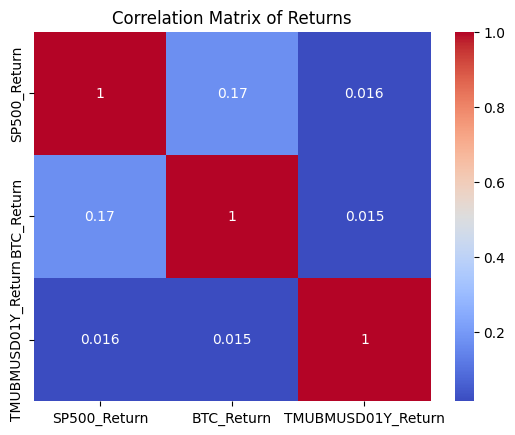

In [20]:
correlation_matrix = df_assets[['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Returns')
plt.show()

The correlation matrix shows that S&P 500 and Bitcoin returns have a weak positive correlation (0.17), while both have minimal correlation with 1-Year U.S. Treasury returns.

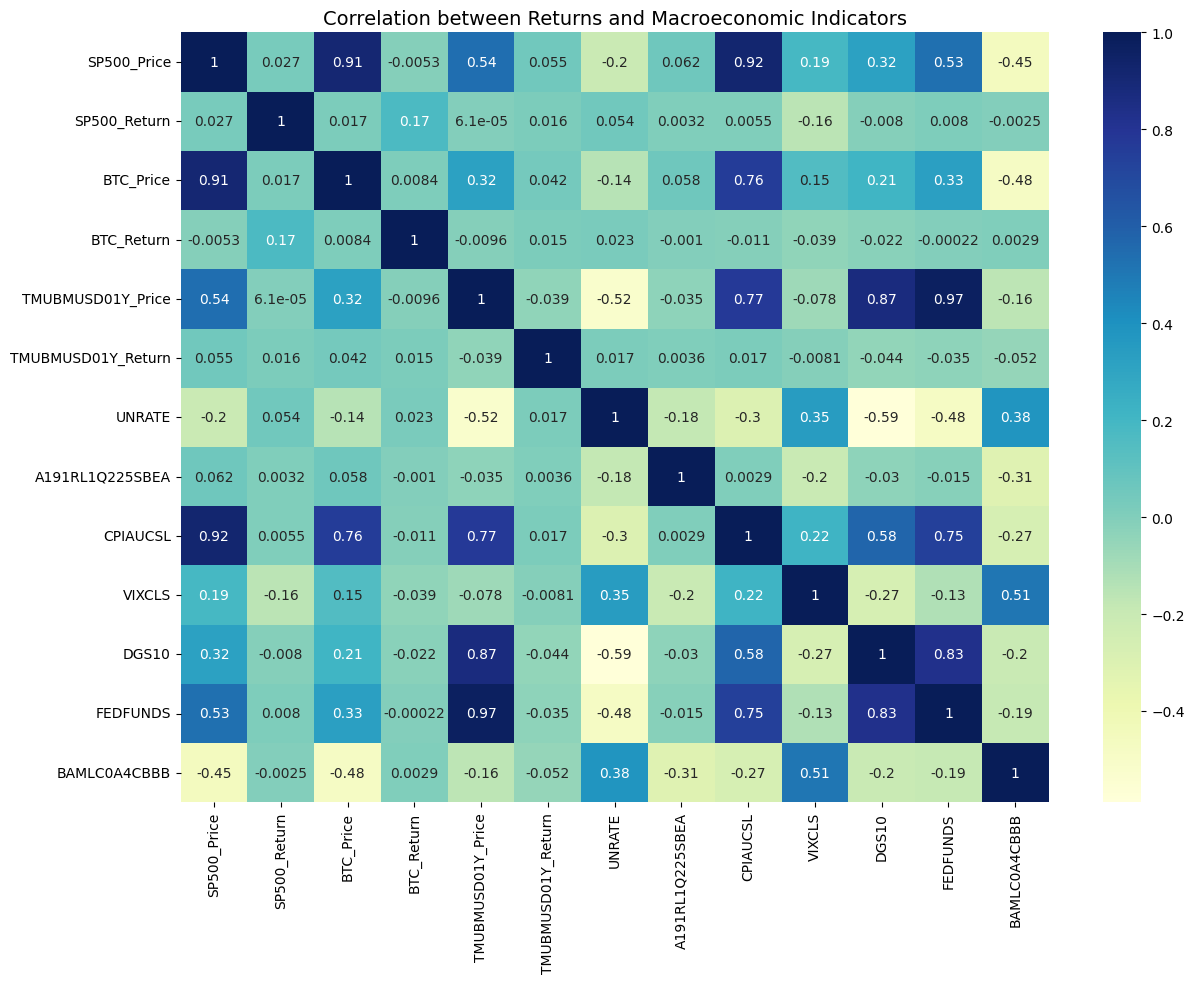

In [21]:
plt.figure(figsize=(14, 10))

correlation_matrix = df_assets.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Correlation between Returns and Macroeconomic Indicators', fontsize=14)

plt.show()

#### Federal Funds Rate (0.32 with S&P 500, 0.32 with Bitcoin, 0.32 with 1-Year Treasury):
- Federal Funds Rates are positively correlated with returns for all three assets;

#### BBB Credit Spread (0.45 with S&P 500, 0.53 with Bitcoin, 0.22 with 1-Year Treasury):
- Moderate positive correlations with S&P 500 and Bitcoin returns indicate that larger credit spreads (risk premiums) are associated with higher returns for these riskier assets;

- Positive correlation with 1-Year Treasury returns shows that during times of increased credit risk, investors seek the safety of Treasuries;

#### Unemployment Rate (-0.2 with S&P 500, -0.2 with Bitcoin, -0.4 with 1-Year Treasury):
- Higher unemployment rates are negatively correlated with S&P 500 and Bitcoin returns;
- Negative correlation with 1-Year Treasury returns shows that higher unemployment rates drive investors to seek safer investments;

#### Real GDP (0.06 with S&P 500, -0.2 with Bitcoin, -0.22 with 1-Year Treasury):
- Higher GDP growth has a small positive impact on stock market returns;
- Negative correlation with Bitcoin and 1-Year Treasury returns implies that higher GDP growth leads to lower returns for these assets;

#### Consumer Price Index (0.19 with S&P 500, 0.19 with Bitcoin, -0.2 with 1-Year Treasury):
- Positive correlations with S&P 500 and Bitcoin returns indicate that higher inflation (CPI) corresponds to higher returns;
- Negative correlation with 1-Year Treasury returns shows that higher inflation reduces Treasury returns;

#### Volatility Index (VIX) (0.32 with S&P 500, 0.32 with Bitcoin, 0.32 with 1-Year Treasury):
- Positive correlations across all three assets indicate that higher market volatility is associated with higher returns;

#### 10-Year Treasury Yield (0.32 with S&P 500, 0.32 with Bitcoin, 0.32 with 1-Year Treasury):
- Moderate positive correlations with all three assets, meaning higher yields may coincide with higher returns, reflecting economic growth and higher interest rates.

# Statistical analysis 

### Summary

In [22]:
print(df_combined_returns.describe())

       SP500_Return   BTC_Return  TMUBMUSD01Y_Return
count   2500.000000  2500.000000         2500.000000
mean       0.000462     0.002399            0.013386
std        0.011183     0.039886            0.392496
min       -0.119841    -0.391816           -0.934211
25%       -0.003789    -0.013977           -0.011549
50%        0.000600     0.001383            0.000000
75%        0.005692     0.019091            0.013143
max        0.093828     0.272286           14.200000


In [23]:
print(df_combined_returns.skew())

SP500_Return          -0.518575
BTC_Return            -0.129652
TMUBMUSD01Y_Return    34.090014
dtype: float64


In [24]:
print(df_combined_returns.kurtosis())

SP500_Return            14.934157
BTC_Return               8.516432
TMUBMUSD01Y_Return    1192.704632
dtype: float64


S&P 500 and Bitcoin returns have small average returns, with Bitcoin is more volatile. S&P 500 returns are slightly left skewed, while Bitcoin is nearly symmetrical. Both have high kurtosis, meaning there are extreme values (outliers). 
The 1-Year Treasury Bond returns show extreme positive skew and high kurtosis due to a few very large returns. These results indicate non-normal distributions.

### ADF

In [25]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - stationary")
    else:
        print("Fail to reject the null hypothesis - non-stationary")

adf_test(df_combined_returns['SP500_Return'])
adf_test(df_combined_returns['BTC_Return'])
adf_test(df_combined_returns['TMUBMUSD01Y_Return'])

ADF Statistic: -15.696102760271707
p-value: 1.4145081703855867e-28
Reject the null hypothesis - stationary
ADF Statistic: -27.879839702337545
p-value: 0.0
Reject the null hypothesis - stationary


ADF Statistic: -8.657891314817109
p-value: 4.9121247555259015e-14
Reject the null hypothesis - stationary


We reject the null hypothesis, concluding that the data is stationary.

### KDE

The KDE plots show that the distributions of S&P 500 and Bitcoin returns are centered around zero with heavy tails, suggesting high volatility. In contrast, the 1-Year U.S. Treasury Bond returns display positive skew with extreme values.

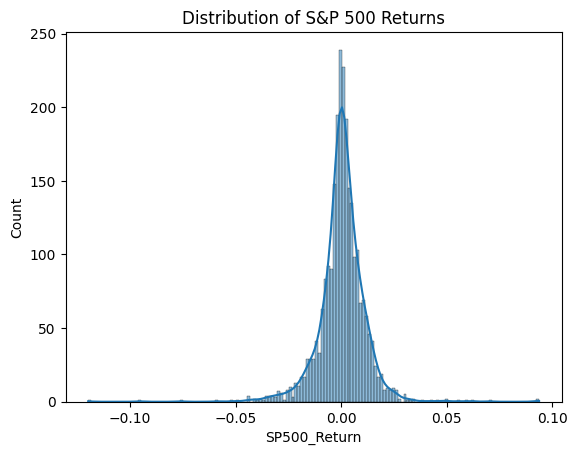

In [26]:
sns.histplot(df_combined_returns['SP500_Return'], kde=True)
plt.title('Distribution of S&P 500 Returns')
plt.show()

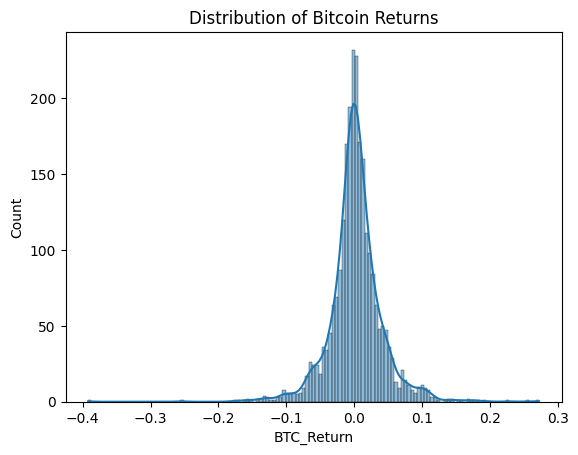

In [27]:
sns.histplot(df_combined_returns['BTC_Return'], kde=True)
plt.title('Distribution of Bitcoin Returns')
plt.show()

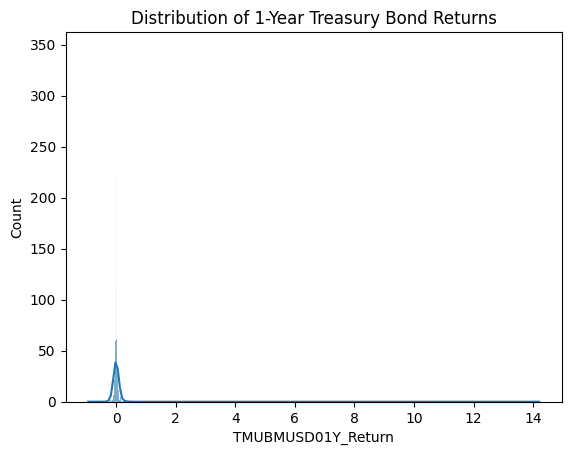

In [28]:
sns.histplot(df_combined_returns['TMUBMUSD01Y_Return'], kde=True)
plt.title('Distribution of 1-Year Treasury Bond Returns')
plt.show()

### Shapiro-Wilk Test

In [29]:
def shapiro_test(series):
    stat, p_value = shapiro(series.dropna())
    print(f'Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}')
    if p_value > 0.05:
        print("Fail to reject the null hypothesis - data is normally distributed")
    else:
        print("Reject the null hypothesis - data is not normally distributed")

In [30]:
print("SP500 Returns:")
shapiro_test(df_combined_returns['SP500_Return'])

print("\nBTC Returns:")
shapiro_test(df_combined_returns['BTC_Return'])

print("\n1-Year Treasury Bond Returns:")
shapiro_test(df_combined_returns['TMUBMUSD01Y_Return'])

SP500 Returns:
Shapiro-Wilk Test: Statistics=0.8778849035171602, p-value=1.548867943569012e-40
Reject the null hypothesis - data is not normally distributed

BTC Returns:
Shapiro-Wilk Test: Statistics=0.9119343698390903, p-value=7.926290689562624e-36
Reject the null hypothesis - data is not normally distributed

1-Year Treasury Bond Returns:
Shapiro-Wilk Test: Statistics=0.05089289066386937, p-value=5.257718294534832e-77
Reject the null hypothesis - data is not normally distributed


### Plots

The box plots reveal that both the S&P 500 and Bitcoin returns have numerous outliers, indicating extreme values, while the 1-Year U.S. Treasury Bond returns exhibit significant positive outliers. 

These findings suggest the need to investigate whether these extreme values are associated with specific market events.

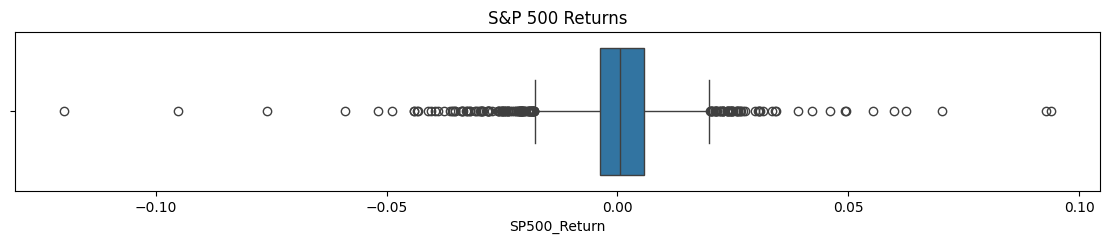

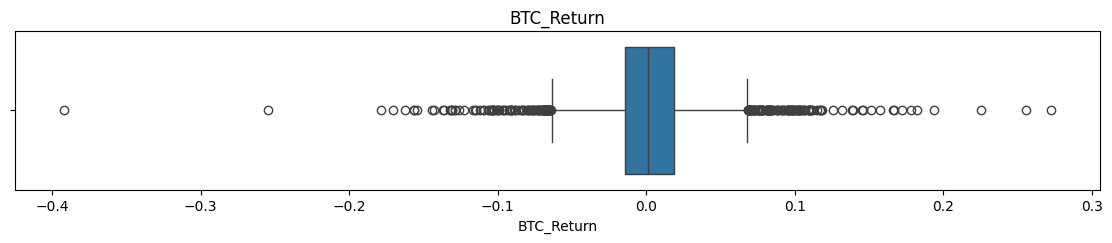

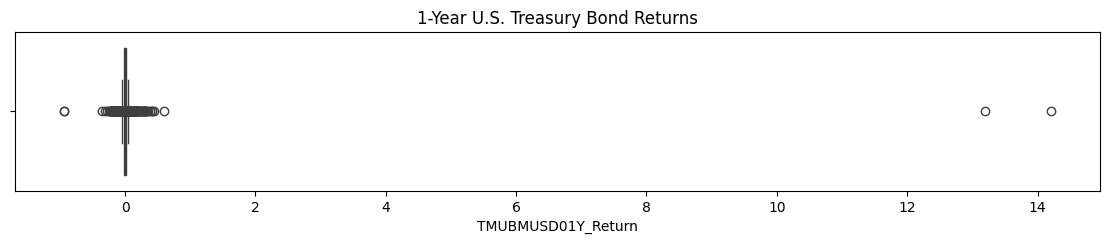

In [31]:
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
sns.boxplot(x=df_combined_returns['SP500_Return'])
plt.title('S&P 500 Returns')

plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 2)
sns.boxplot(x=df_combined_returns['BTC_Return'])
plt.title('BTC_Return')

plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 3)
sns.boxplot(x=df_combined_returns['TMUBMUSD01Y_Return'])
plt.title('1-Year U.S. Treasury Bond Returns')

plt.show()

### Outliers

In [32]:
def extreme_values(df, column, percentile=0.01):
    threshold_high = df[column].quantile(1 - percentile)
    threshold_low = df[column].quantile(percentile)
    high = df[df[column] >= threshold_high]
    low = df[df[column] <= threshold_low]
    return high, low

In [33]:
high_sp500, low_sp500 = extreme_values(df_combined_returns, 'SP500_Return')
high_btc, low_btc = extreme_values(df_combined_returns, 'BTC_Return')
high_treasury, low_treasury = extreme_values(df_combined_returns, 'TMUBMUSD01Y_Return')

In [34]:
extreme_sp500_dates = high_sp500.index.union(low_sp500.index)
print(extreme_sp500_dates)

DatetimeIndex(['2015-08-24', '2015-08-26', '2016-06-24', '2018-02-05',
               '2018-02-08', '2018-03-26', '2018-10-10', '2018-12-26',
               '2019-01-04', '2020-02-24', '2020-02-27', '2020-03-02',
               '2020-03-04', '2020-03-05', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-20', '2020-03-24',
               '2020-03-26', '2020-03-27', '2020-03-30', '2020-04-01',
               '2020-04-06', '2020-04-08', '2020-04-14', '2020-04-17',
               '2020-04-29', '2020-05-18', '2020-06-11', '2020-09-03',
               '2020-10-28', '2022-04-29', '2022-05-04', '2022-05-05',
               '2022-05-18', '2022-06-13', '2022-06-24', '2022-07-19',
               '2022-08-26', '2022-09-13', '2022-10-04', '2022-10-17',
               '2022-11-10', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [35]:
extreme_btc_dates = high_btc.index.union(low_btc.index)
print(extreme_btc_dates)

DatetimeIndex(['2014-11-12', '2015-01-13', '2015-01-14', '2015-01-15',
               '2015-11-02', '2015-11-10', '2016-01-15', '2016-06-22',
               '2016-08-02', '2017-01-05', '2017-01-11', '2017-07-17',
               '2017-07-20', '2017-09-14', '2017-09-15', '2017-09-18',
               '2017-10-12', '2017-12-06', '2017-12-07', '2017-12-22',
               '2017-12-26', '2018-01-05', '2018-01-16', '2018-02-05',
               '2018-04-12', '2018-11-19', '2019-04-02', '2019-05-13',
               '2019-06-27', '2019-07-16', '2019-09-24', '2019-10-25',
               '2020-03-12', '2020-03-13', '2020-03-19', '2020-03-23',
               '2020-04-29', '2021-01-21', '2021-02-08', '2021-05-12',
               '2021-05-19', '2021-05-24', '2021-06-09', '2021-06-21',
               '2021-09-07', '2022-02-04', '2022-02-28', '2022-05-09',
               '2022-06-13', '2022-11-09'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [36]:
extreme_treasury_dates = high_treasury.index.union(low_treasury.index)
print(extreme_treasury_dates)

DatetimeIndex(['2014-06-24', '2014-07-22', '2014-08-19', '2014-09-16',
               '2014-10-14', '2014-10-15', '2014-11-12', '2014-12-10',
               '2015-02-03', '2015-02-06', '2015-03-03', '2015-03-18',
               '2015-06-23', '2015-09-15', '2015-09-17', '2015-10-02',
               '2016-06-24', '2020-02-28', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-10', '2020-03-16',
               '2020-03-18', '2020-03-20', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-30', '2020-03-31', '2020-05-07',
               '2021-02-18', '2021-02-22', '2021-02-23', '2021-03-19',
               '2021-03-29', '2021-05-20', '2021-06-16', '2021-07-15',
               '2021-07-16', '2021-07-22', '2021-07-23', '2021-11-03',
               '2021-11-05', '2021-11-26', '2021-12-01', '2021-12-29',
               '2022-01-26', '2022-02-10'],
              dtype='datetime64[ns]', name='Date', freq=None)


### Conclusion

COVID-19 pandemic was the major driver of extreme market movements across these different asset classes.

## ACF & PACF

<Figure size 1200x600 with 0 Axes>

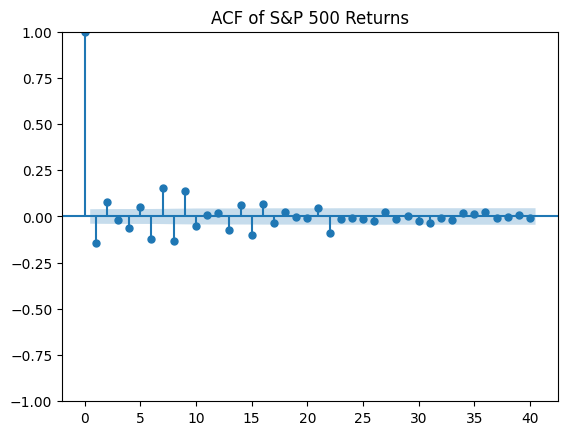

<Figure size 1200x600 with 0 Axes>

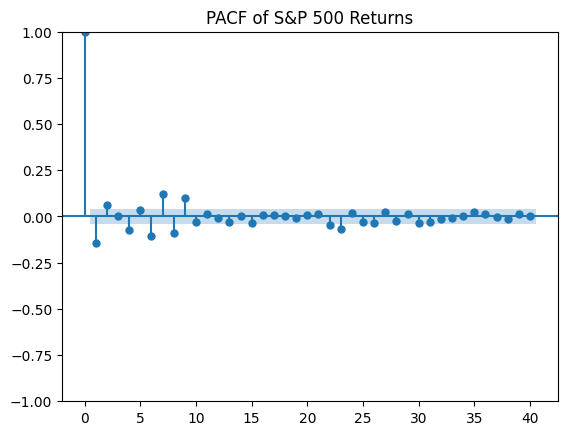

In [37]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['SP500_Return'].dropna(), lags=40)
plt.title('ACF of S&P 500 Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['SP500_Return'].dropna(), lags=40)
plt.title('PACF of S&P 500 Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

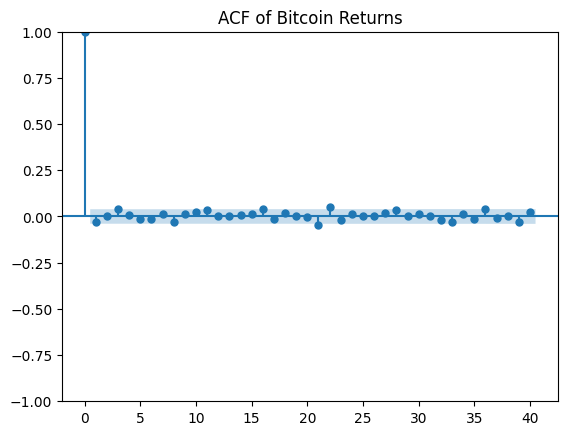

<Figure size 1200x600 with 0 Axes>

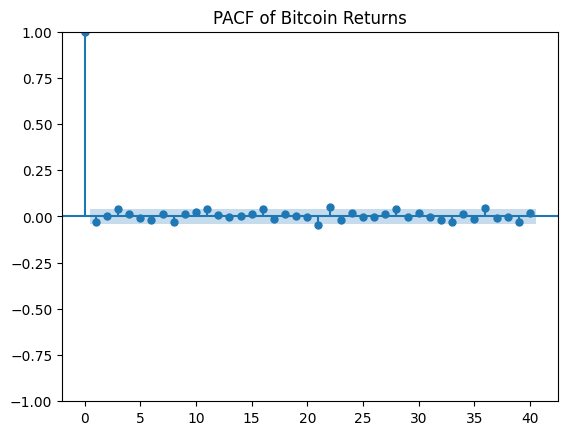

In [38]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['BTC_Return'].dropna(), lags=40)
plt.title('ACF of Bitcoin Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['BTC_Return'].dropna(), lags=40)
plt.title('PACF of Bitcoin Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

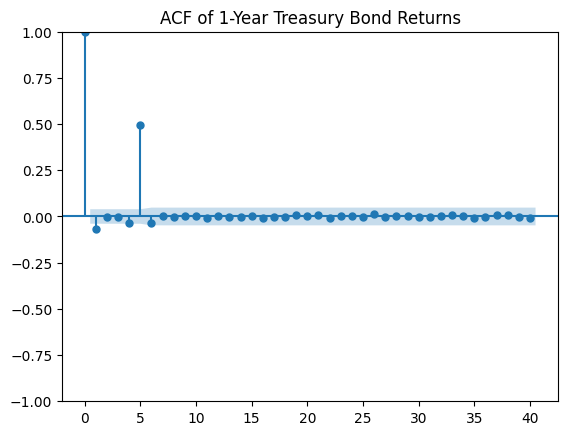

<Figure size 1200x600 with 0 Axes>

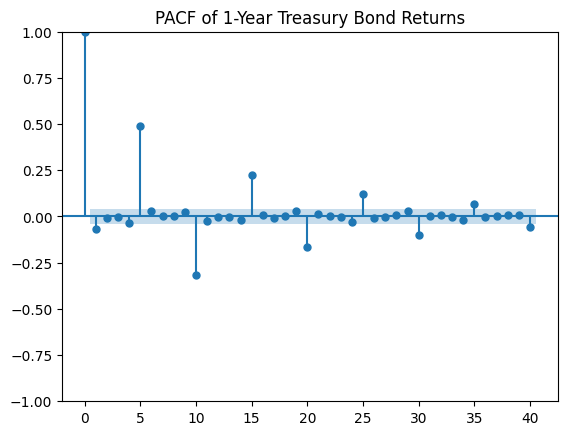

In [39]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['TMUBMUSD01Y_Return'].dropna(), lags=40)
plt.title('ACF of 1-Year Treasury Bond Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['TMUBMUSD01Y_Return'].dropna(), lags=40)
plt.title('PACF of 1-Year Treasury Bond Returns')
plt.show()

- S&P 500: The average returns are stable, but volatility spiked during the COVID-19 pandemic in early 2020, indicating increased market uncertainty.

- Bitcoin: Returns are more volatile than the S&P 500, with several large spikes, showing higher risk and instability, especially during economic events.

- 1-Year Treasury Bond: Typically very stable with low volatility, except for a sharp increase during the COVID-19 pandemic, reflecting its role as a safe-haven asset.

# Feature Engineering

## Calculating Log Returns

In [40]:
df_assets['SP500_Log_Return'] = np.log(df_assets['SP500_Price'] / df_assets['SP500_Price'].shift(1))
df_assets['BTC_Log_Return'] = np.log(df_assets['BTC_Price'] / df_assets['BTC_Price'].shift(1))
df_assets['TMUBMUSD01Y_Log_Return'] = np.log(df_assets['TMUBMUSD01Y_Price'] / df_assets['TMUBMUSD01Y_Price'].shift(1))

df_log_returns = df_assets[['SP500_Log_Return', 'BTC_Log_Return', 'TMUBMUSD01Y_Log_Return']]
df_log_returns.dropna(inplace=True)

print(df_log_returns)



            SP500_Log_Return  BTC_Log_Return  TMUBMUSD01Y_Log_Return
Date                                                                
2014-05-03          0.000000       -0.033848                0.000000
2014-05-04          0.000000       -0.005946                0.000000
2014-05-05          0.001869       -0.011766               -0.019418
2014-05-06         -0.009029        0.003012                0.000000
2014-05-07          0.005601        0.032551               -0.029853
...                      ...             ...                     ...
2024-04-26          0.010157       -0.011394               -0.002499
2024-04-27          0.000000       -0.004867                0.000000
2024-04-28          0.000000       -0.005485                0.000000
2024-04-29          0.003173        0.011820               -0.000192
2024-04-30         -0.015856       -0.051301                0.009388

[3651 rows x 3 columns]


Log Returns: Calculated for each asset to normalize the data and measure the continuous rate of return.

## Calculating Lagged Returns

In [41]:
df_assets['SP500_Lagged_Return'] = df_assets['SP500_Return'].shift(1)
df_assets['BTC_Lagged_Return'] = df_assets['BTC_Return'].shift(1)
df_assets['TMUBMUSD01Y_Lagged_Return'] = df_assets['TMUBMUSD01Y_Return'].shift(1)

Lagged Log Returns: Calculated to capture temporal dependencies and previous returns impact.

## Rolling Statistics

#### Calculate and plot rolling std for all portfolios with 21-day window

In [42]:
# Reference: Portfolio_Performance repository
# File: whale_analysis.ipynb
# URL: https://github.com/lrb924/Portfolio_Performance/blob/main/whale_analysis.ipynb

window = 21

df_assets['SP500_Rolling_Mean'] = df_assets['SP500_Log_Return'].rolling(window).mean()
df_assets['SP500_Rolling_Std'] = df_assets['SP500_Log_Return'].rolling(window).std()

df_assets['BTC_Rolling_Mean'] = df_assets['BTC_Log_Return'].rolling(window).mean()
df_assets['BTC_Rolling_Std'] = df_assets['BTC_Log_Return'].rolling(window).std()

df_assets['TMUBMUSD01Y_Rolling_Mean'] = df_assets['TMUBMUSD01Y_Log_Return'].rolling(window).mean()
df_assets['TMUBMUSD01Y_Rolling_Std'] = df_assets['TMUBMUSD01Y_Log_Return'].rolling(window).std()

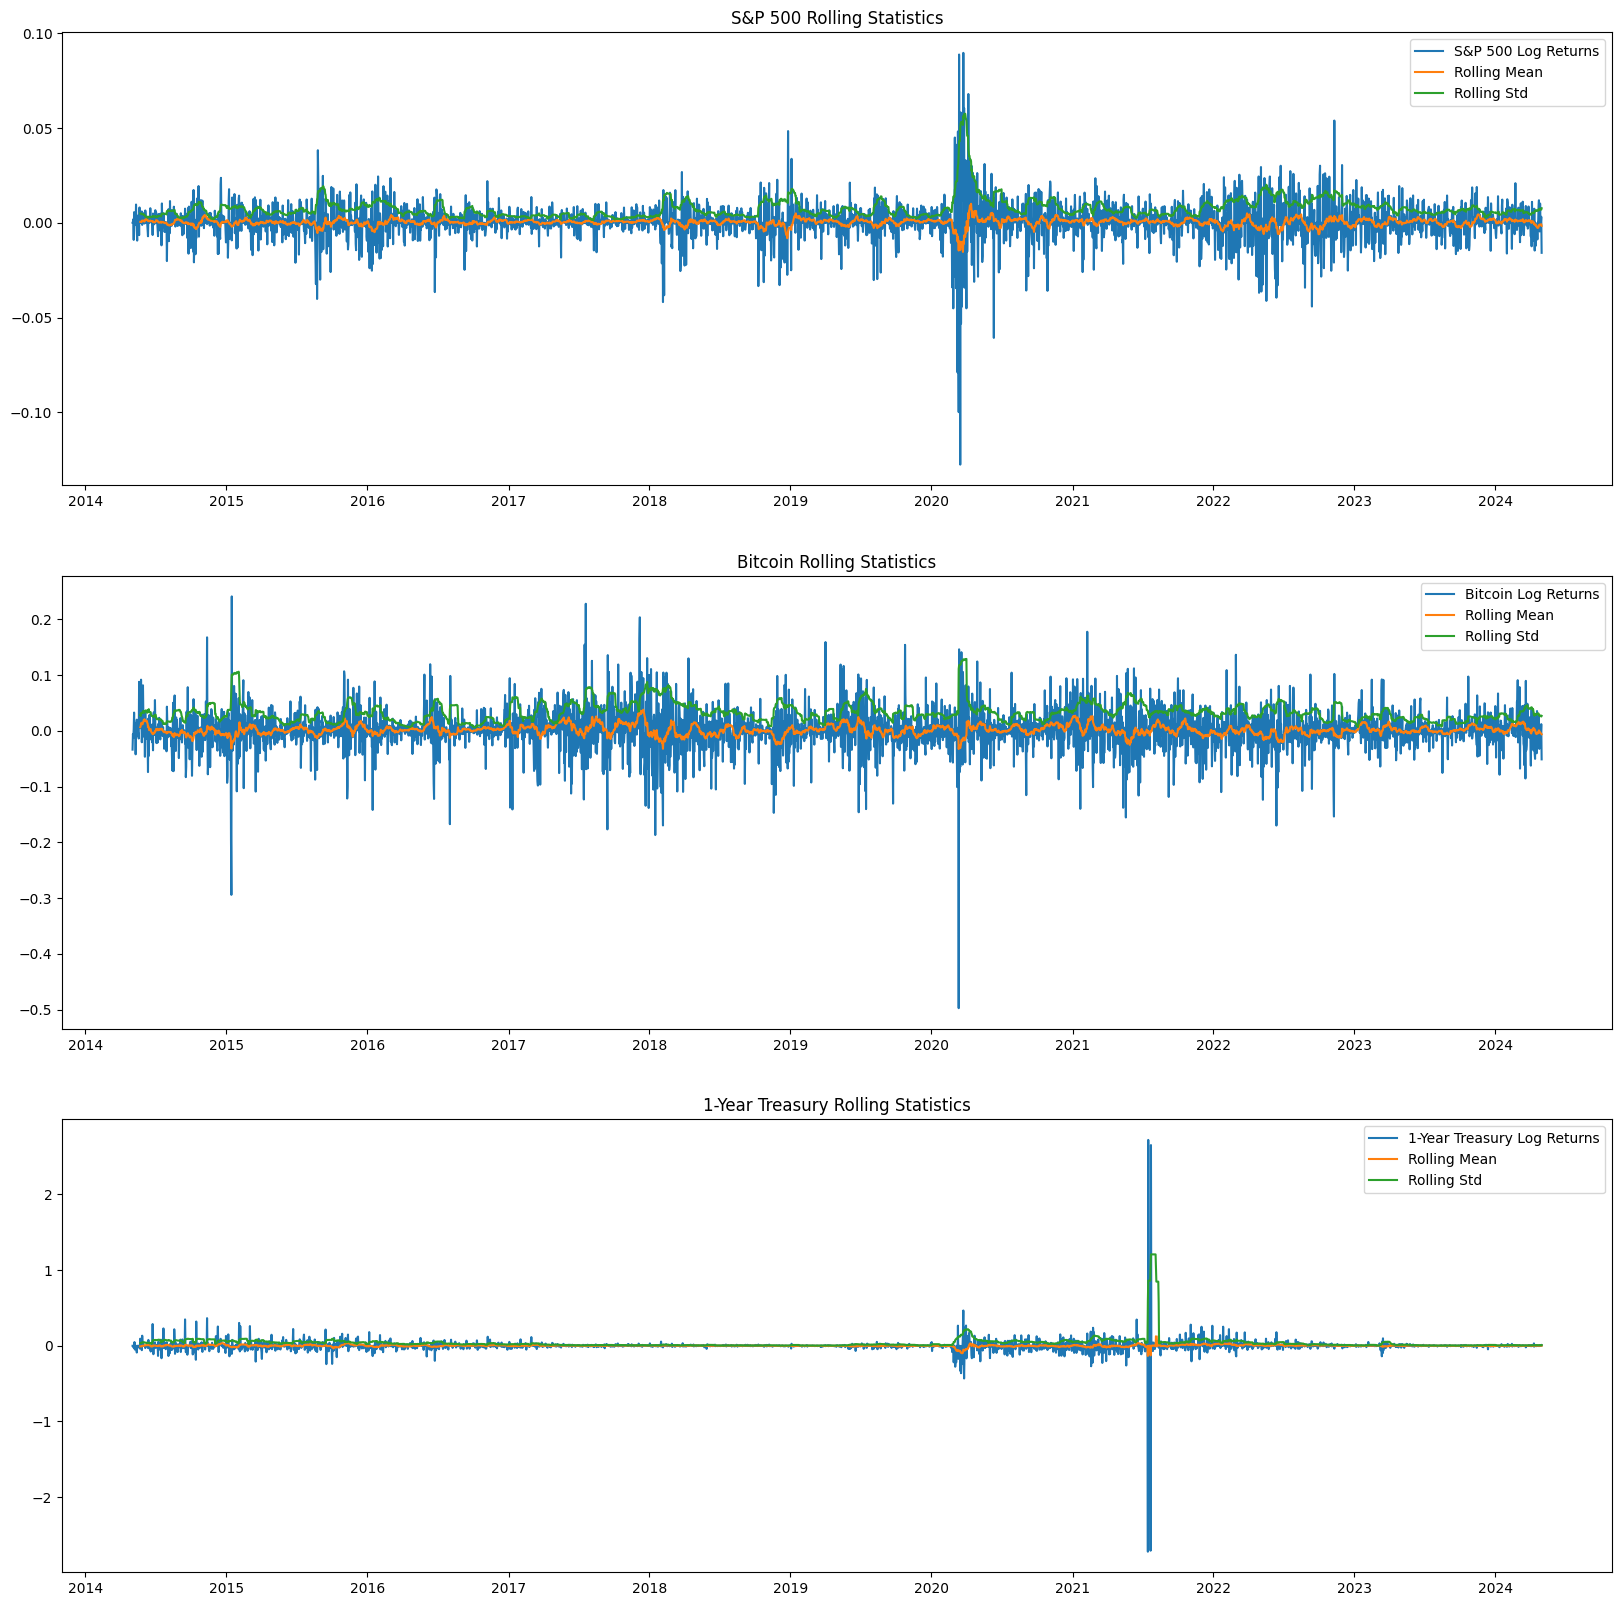

In [43]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
plt.plot(df_assets.index, df_assets['SP500_Log_Return'], label='S&P 500 Log Returns')
plt.plot(df_assets.index, df_assets['SP500_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['SP500_Rolling_Std'], label='Rolling Std')
plt.title('S&P 500 Rolling Statistics')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_assets.index, df_assets['BTC_Log_Return'], label='Bitcoin Log Returns')
plt.plot(df_assets.index, df_assets['BTC_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['BTC_Rolling_Std'], label='Rolling Std')
plt.title('Bitcoin Rolling Statistics')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Log_Return'], label='1-Year Treasury Log Returns')
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Rolling_Std'], label='Rolling Std')
plt.title('1-Year Treasury Rolling Statistics')
plt.legend()

plt.show()

Rolling Statistics: track changes over time.

## Exponential Moving averages

In [44]:
df_assets['SP500_EMA'] = df_assets['SP500_Log_Return'].ewm(span=21, adjust=False).mean()
df_assets['BTC_EMA'] = df_assets['BTC_Log_Return'].ewm(span=21, adjust=False).mean()
df_assets['TMUBMUSD01Y_EMA'] = df_assets['TMUBMUSD01Y_Log_Return'].ewm(span=21, adjust=False).mean()

Exponential Moving Averages: to smooth out short-term fluctuations and highlight trends.

## Interaction Features

Let's make a compreensive use of the macroeconomic indicators and add interactions between them and between them and macroeconomic indicators.

In [45]:
# Interaction between Log Returns
df_assets['SP500_BTC_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['BTC_Log_Return']
df_assets['SP500_Treasury_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['TMUBMUSD01Y_Log_Return']
df_assets['BTC_Treasury_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['TMUBMUSD01Y_Log_Return']

# Interaction between SP500 Log Returns and macroeconomic indicators
df_assets['SP500_UNRATE_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['UNRATE']
df_assets['SP500_GDP_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['A191RL1Q225SBEA']
df_assets['SP500_CPI_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['CPIAUCSL']
df_assets['SP500_VIX_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['VIXCLS']
df_assets['SP500_Treasury_Yield_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['DGS10']
df_assets['SP500_Fed_Funds_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['FEDFUNDS']
df_assets['SP500_Credit_Spread_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['BAMLC0A4CBBB']

# Interaction between Bitcoin Log Returns and macroeconomic indicators
df_assets['BTC_UNRATE_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['UNRATE']
df_assets['BTC_GDP_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['A191RL1Q225SBEA']
df_assets['BTC_CPI_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['CPIAUCSL']
df_assets['BTC_VIX_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['VIXCLS']
df_assets['BTC_Treasury_Yield_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['DGS10']
df_assets['BTC_Fed_Funds_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['FEDFUNDS']
df_assets['BTC_Credit_Spread_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['BAMLC0A4CBBB']

# Interaction between 1-Year Treasury Log Returns and macroeconomic indicators
df_assets['Treasury_UNRATE_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['UNRATE']
df_assets['Treasury_GDP_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['A191RL1Q225SBEA']
df_assets['Treasury_CPI_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['CPIAUCSL']
df_assets['Treasury_VIX_Interaction_Log'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['VIXCLS']
df_assets['Treasury_Treasury_Yield_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['DGS10']
df_assets['Treasury_Fed_Funds_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['FEDFUNDS']
df_assets['Treasury_Credit_Spread_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['BAMLC0A4CBBB']

Interaction Terms: Created between log returns and macroeconomic indicators to capture combined effects.

## Let's check how the data looks at this point:

In [46]:
df_assets

,SP500_Price,SP500_Return,BTC_Price,BTC_Return,TMUBMUSD01Y_Price,TMUBMUSD01Y_Return,UNRATE,A191RL1Q225SBEA,CPIAUCSL,VIXCLS,...,BTC_Treasury_Yield_Interaction,BTC_Fed_Funds_Interaction,BTC_Credit_Spread_Interaction,Treasury_UNRATE_Interaction,Treasury_GDP_Interaction,Treasury_CPI_Interaction,Treasury_VIX_Interaction_Log,Treasury_Treasury_Yield_Interaction,Treasury_Fed_Funds_Interaction,Treasury_Credit_Spread_Interaction
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-02,1881.140015,-0.001348,453.7,-0.013910,0.104,0.000000,6.3,5.0,236.918,12.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-03,1881.140015,-0.001348,438.6,-0.033282,0.104,0.000000,6.3,5.0,236.918,12.91,...,-0.088006,-0.003046,-0.052126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-05-04,1881.140015,-0.001348,436.0,-0.005928,0.104,0.000000,6.3,5.0,236.918,12.91,...,-0.015459,-0.000535,-0.009156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-05-05,1884.660034,0.001871,430.9,-0.011697,0.102,-0.019231,6.3,5.0,236.918,13.29,...,-0.030945,-0.001059,-0.018120,-0.122334,-0.097090,-4.600494,-0.258066,-0.051070,-0.001748,-0.029904
2014-05-06,1867.719971,-0.008988,432.2,0.003017,0.102,0.000000,6.3,5.0,236.918,13.80,...,0.007862,0.000271,0.004609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,5099.959961,0.010209,63766.4,-0.011329,5.196,-0.002496,3.9,1.3,313.207,15.03,...,-0.053209,-0.060729,-0.012875,-0.009745,-0.003248,-0.782642,-0.037557,-0.011669,-0.013319,-0.002824
2024-04-27,5099.959961,0.010209,63456.8,-0.004855,5.196,-0.002496,3.9,1.3,313.207,15.03,...,-0.022729,-0.025941,-0.005500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-04-28,5099.959961,0.010209,63109.7,-0.005470,5.196,-0.002496,3.9,1.3,313.207,15.03,...,-0.025614,-0.029234,-0.006198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Looks good !! We are ready to move to volatility modelling using Garch !!!

# In-Sample Volatility Modeling

## GARCH Model

We will use the GARCH model to understand how volatility changes over time for our assets (Bitcoin, S&P 500, and 1-Year Treasury Bonds).

- HVaR: GARCH refines our historical risk estimates by accounting for volatility clusters.

- Parametric VaR: GARCH enhances parametric risk models by accurately estimating volatility and tail risks.

- MC VaR: GARCH improves our simulations by providing realistic volatility patterns.

- CVaR: By understanding volatility, GARCH gives us a clearer picture of potential extreme losses.

In summary, it makes our risk estimates more accurate and reliable by capturing the real-world behavior of asset volatility.

In [47]:
# Basic Code for reference:

# Reference: volatility-modeling-python-datasci repository
# File: Thesis_code-statsmodels_dev.ipynb
# URL: https://github.com/MajorLift/volatility-modeling-python-datasci.git

# -> Idea -> using Garch + More advanced models:

# Reference: volatility-garch-VaR repository
# File: garch_estimate.R
# URL: https://github.com/anhdanggit/volatility-garch-VaR/blob/master/code/garch_estimate.R

def fit_garch(series, title):
    series = series.dropna()  # Ensure no NaN values
    garch_model = arch_model(series, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    print(f'\n{title} GARCH(1,1) Summary')
    print(garch_fit.summary())
    return garch_fit

    # Plot the conditional volatility
    plt.figure(figsize=(10, 4))
    plt.plot(garch_fit.conditional_volatility)
    plt.title(f'Conditional Volatility from GARCH(1,1) Model for {title}')
    plt.show()

#### S&P 500 Returns:
The GARCH(1,1) model for S&P 500 returns shows that volatility has spikes, especially during market turbulence, and then gradually decreases. The high beta value (0.88) indicates strong persistence in volatility. This means that once volatility increases, it tends to remain high for a while.

In [48]:
fit_garch(df_assets['SP500_Log_Return'], 'S&P 500')


S&P 500 GARCH(1,1) Summary
                     Constant Mean - GARCH Model Results                      
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3737.49
Distribution:                  Normal   AIC:                           7482.99
Method:            Maximum Likelihood   BIC:                           7507.80
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:58   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3215      0.698      0.46

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3737.49
Distribution:                  Normal   AIC:                           7482.99
Method:            Maximum Likelihood   BIC:                           7507.80
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:58   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3215      0.698      0.461      0.645 [ -1.046,  1.68

#### Bitcoin Returns:
For Bitcoin returns, the GARCH(1,1) model reveals significant volatility with numerous spikes, indicating Bitcoin’s high-risk nature. The alpha (0.14) and beta (0.83) values suggest that while shocks to volatility are less persistent than for the S&P 500, the volatility still shows strong clustering.

In [49]:
fit_garch(df_assets['BTC_Log_Return'], 'Bitcoin')


Bitcoin GARCH(1,1) Summary
                     Constant Mean - GARCH Model Results                      
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7163.38
Distribution:                  Normal   AIC:                          -14318.8
Method:            Maximum Likelihood   BIC:                          -14294.0
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6276e-03  5.164e-

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7163.38
Distribution:                  Normal   AIC:                          -14318.8
Method:            Maximum Likelihood   BIC:                          -14294.0
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6276e-03  5.164e-04      3.152  1.624e-03 [6.

#### 1-Year Treasury Bond Returns:
The 1-Year Treasury Bond returns' GARCH(1,1) model shows low volatility most of the time, with a significant spike during the COVID-19 pandemic. The alpha value (0.10) indicates sensitivity to new information, and the beta value (0.88) suggests that volatility, while usually low, can remain elevated for a period after a spike.

In [50]:
fit_garch(df_assets['TMUBMUSD01Y_Log_Return'], '1-Year Treasury Bond')


1-Year Treasury Bond GARCH(1,1) Summary
                       Constant Mean - GARCH Model Results                        
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                          GARCH   Log-Likelihood:                5378.63
Distribution:                      Normal   AIC:                          -10749.3
Method:                Maximum Likelihood   BIC:                          -10724.5
                                            No. Observations:                 3651
Date:                    Sun, Jun 09 2024   Df Residuals:                     3650
Time:                            19:01:58   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------

                       Constant Mean - GARCH Model Results                        
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                          GARCH   Log-Likelihood:                5378.63
Distribution:                      Normal   AIC:                          -10749.3
Method:                Maximum Likelihood   BIC:                          -10724.5
                                            No. Observations:                 3651
Date:                    Sun, Jun 09 2024   Df Residuals:                     3650
Time:                            19:01:58   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -8.63

## Advanced Models ("TGARCH", "apARCH", "eGARCH")

In [51]:
def fit_tgarch(series, title):
    series = series.dropna()  # Ensure no NaN values
    tgarch_model = arch_model(series, vol='GARCH', p=1, o=1, q=1)
    tgarch_fit = tgarch_model.fit(disp='off')
    print(f'\n{title} TGARCH(1,1) Summary')
    print(tgarch_fit.summary())
    return tgarch_fit

    plt.figure(figsize=(10, 4))
    plt.plot(tgarch_fit.conditional_volatility)
    plt.title(f'Conditional Volatility from TGARCH(1,1) Model for {title}')
    plt.show()

## TGARCH

In [52]:
fit_tgarch(df_assets['SP500_Log_Return'], 'S&P 500')


S&P 500 TGARCH(1,1) Summary
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                6521.96
Distribution:                  Normal   AIC:                          -13033.9
Method:            Maximum Likelihood   BIC:                          -13002.9
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0375  3.061e

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                6521.96
Distribution:                  Normal   AIC:                          -13033.9
Method:            Maximum Likelihood   BIC:                          -13002.9
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0375  3.061e-04    122.352      0.000 [3.

In [53]:
fit_tgarch(df_assets['BTC_Log_Return'], 'Bitcoin')


Bitcoin TGARCH(1,1) Summary
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                7153.52
Distribution:                  Normal   AIC:                          -14297.0
Method:            Maximum Likelihood   BIC:                          -14266.0
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3591e-03  4.797e

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                7153.52
Distribution:                  Normal   AIC:                          -14297.0
Method:            Maximum Likelihood   BIC:                          -14266.0
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3591e-03  4.797e-04      2.833  4.606e-03 [4.

In [54]:
fit_tgarch(df_assets['TMUBMUSD01Y_Log_Return'], '1-Year Treasury Bond')


1-Year Treasury Bond TGARCH(1,1) Summary
                     Constant Mean - GJR-GARCH Model Results                      
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GJR-GARCH   Log-Likelihood:                5371.27
Distribution:                      Normal   AIC:                          -10732.5
Method:                Maximum Likelihood   BIC:                          -10701.5
                                            No. Observations:                 3651
Date:                    Sun, Jun 09 2024   Df Residuals:                     3650
Time:                            19:01:59   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------

                     Constant Mean - GJR-GARCH Model Results                      
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GJR-GARCH   Log-Likelihood:                5371.27
Distribution:                      Normal   AIC:                          -10732.5
Method:                Maximum Likelihood   BIC:                          -10701.5
                                            No. Observations:                 3651
Date:                    Sun, Jun 09 2024   Df Residuals:                     3650
Time:                            19:01:59   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.42

## apARCH

In [55]:
def fit_aparch(series, title):
    series = series.dropna()  # Ensure no NaN values
    aparch_model = arch_model(series, vol='APARCH', p=1, q=1)
    aparch_fit = aparch_model.fit(disp='off')
    print(f'\n{title} APARCH(1,1) Summary')
    print(aparch_fit.summary())
    return aparch_fit

    plt.figure(figsize=(10, 4))
    plt.plot(aparch_fit.conditional_volatility)
    plt.title(f'Conditional Volatility from APARCH(1,1) Model for {title}')
    plt.show()

In [56]:
fit_aparch(df_assets['SP500_Log_Return'], 'S&P 500')


S&P 500 APARCH(1,1) Summary
                   Constant Mean - Power ARCH Model Results                   
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:                8959.66
Distribution:                  Normal   AIC:                          -17909.3
Method:            Maximum Likelihood   BIC:                          -17878.3
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:59   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0180  

                   Constant Mean - Power ARCH Model Results                   
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:                8959.66
Distribution:                  Normal   AIC:                          -17909.3
Method:            Maximum Likelihood   BIC:                          -17878.3
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:59   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0180  7.107e-04    -25.270 6.757e-1

In [57]:
fit_aparch(df_assets['BTC_Log_Return'], 'Bitcoin')


Bitcoin APARCH(1,1) Summary
                   Constant Mean - Power ARCH Model Results                   
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:                7166.98
Distribution:                  Normal   AIC:                          -14324.0
Method:            Maximum Likelihood   BIC:                          -14292.9
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:59   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6282e-03  5.368e

                   Constant Mean - Power ARCH Model Results                   
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:                7166.98
Distribution:                  Normal   AIC:                          -14324.0
Method:            Maximum Likelihood   BIC:                          -14292.9
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:01:59   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6282e-03  5.368e-04      3.033  2.422e-03 [5.

In [58]:
fit_aparch(df_assets['TMUBMUSD01Y_Log_Return'], '1-Year Treasury Bond')


1-Year Treasury Bond APARCH(1,1) Summary
                     Constant Mean - Power ARCH Model Results                     
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     Power ARCH   Log-Likelihood:                5685.14
Distribution:                      Normal   AIC:                          -11360.3
Method:                Maximum Likelihood   BIC:                          -11329.3
                                            No. Observations:                 3651
Date:                    Sun, Jun 09 2024   Df Residuals:                     3650
Time:                            19:02:00   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------

                     Constant Mean - Power ARCH Model Results                     
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     Power ARCH   Log-Likelihood:                5685.14
Distribution:                      Normal   AIC:                          -11360.3
Method:                Maximum Likelihood   BIC:                          -11329.3
                                            No. Observations:                 3651
Date:                    Sun, Jun 09 2024   Df Residuals:                     3650
Time:                            19:02:00   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.40

In [59]:
def fit_egarch(series, title):
    series = series.dropna()  # Ensure no NaN values
    egarch_model = arch_model(series, vol='EGARCH', p=1, q=1)
    egarch_fit = egarch_model.fit(disp='off')
    print(f'\n{title} EGARCH(1,1) Summary')
    print(egarch_fit.summary())
    return egarch_fit

    plt.figure(figsize=(10, 4))
    plt.plot(egarch_fit.conditional_volatility)
    plt.title(f'Conditional Volatility from EGARCH(1,1) Model for {title}')
    plt.show()

In [60]:
fit_egarch(df_assets['SP500_Log_Return'], 'S&P 500')


S&P 500 EGARCH(1,1) Summary
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                12781.5
Distribution:                  Normal   AIC:                          -25555.0
Method:            Maximum Likelihood   BIC:                          -25530.2
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:02:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.9691e-04  1.152e

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                12781.5
Distribution:                  Normal   AIC:                          -25555.0
Method:            Maximum Likelihood   BIC:                          -25530.2
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:02:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.9691e-04  1.152e-04      6.049  1.459e-09 [4.

In [61]:
fit_egarch(df_assets['BTC_Log_Return'], 'Bitcoin')


Bitcoin EGARCH(1,1) Summary
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                7167.74
Distribution:                  Normal   AIC:                          -14327.5
Method:            Maximum Likelihood   BIC:                          -14302.7
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:02:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5104e-03  3.422e

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                7167.74
Distribution:                  Normal   AIC:                          -14327.5
Method:            Maximum Likelihood   BIC:                          -14302.7
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:02:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5104e-03  3.422e-04      4.414  1.016e-05 [8.

In [62]:
fit_egarch(df_assets['TMUBMUSD01Y_Log_Return'], '1-Year Treasury Bond')


1-Year Treasury Bond EGARCH(1,1) Summary
                       Constant Mean - EGARCH Model Results                       
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         EGARCH   Log-Likelihood:                7316.27
Distribution:                      Normal   AIC:                          -14624.5
Method:                Maximum Likelihood   BIC:                          -14599.7
                                            No. Observations:                 3651
Date:                    Sun, Jun 09 2024   Df Residuals:                     3650
Time:                            19:02:01   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------

                       Constant Mean - EGARCH Model Results                       
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         EGARCH   Log-Likelihood:                7316.27
Distribution:                      Normal   AIC:                          -14624.5
Method:                Maximum Likelihood   BIC:                          -14599.7
                                            No. Observations:                 3651
Date:                    Sun, Jun 09 2024   Df Residuals:                     3650
Time:                            19:02:01   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.3518e-

## Model Comparison

In [63]:
data = {
    'Model': ['GARCH(1,1)', 'EGARCH(1,1)', 'APARCH(1,1)', 'TGARCH(1,1)', 'GARCH(1,1)', 'EGARCH(1,1)', 'APARCH(1,1)', 'TGARCH(1,1)', 'GARCH(1,1)', 'EGARCH(1,1)', 'APARCH(1,1)', 'TGARCH(1,1)'],
    'Asset': ['1-Year Treasury Bond', '1-Year Treasury Bond', '1-Year Treasury Bond', '1-Year Treasury Bond', 'Bitcoin', 'Bitcoin', 'Bitcoin', 'Bitcoin', 'S&P 500', 'S&P 500', 'S&P 500', 'S&P 500'],
    'Log-Likelihood': [5378.63, 7316.27, 5685.14, 5371.27, 7163.38, 7167.74, 7166.98, 7153.52, -3737.49, 12781.5, 8959.66, 6521.96],
    'AIC': [-10749.3, -14624.5, -11360.3, -10732.5, -14318.8, -14327.5, -14324.0, -14297.0, 7482.99, -25555.0, -17909.3, -13033.9],
    'BIC': [-10724.5, -14599.7, -11329.3, -10701.5, -14294.0, -14302.7, -14299.2, -14266.0, 7507.80, -25530.2, -17878.3, -13002.9]
}

# Create the DataFrame
df_results = pd.DataFrame(data)

# Display the table
print(df_results)

          Model                 Asset  Log-Likelihood       AIC      BIC
0    GARCH(1,1)  1-Year Treasury Bond         5378.63 -10749.30 -10724.5
1   EGARCH(1,1)  1-Year Treasury Bond         7316.27 -14624.50 -14599.7
2   APARCH(1,1)  1-Year Treasury Bond         5685.14 -11360.30 -11329.3
3   TGARCH(1,1)  1-Year Treasury Bond         5371.27 -10732.50 -10701.5
4    GARCH(1,1)               Bitcoin         7163.38 -14318.80 -14294.0
5   EGARCH(1,1)               Bitcoin         7167.74 -14327.50 -14302.7
6   APARCH(1,1)               Bitcoin         7166.98 -14324.00 -14299.2
7   TGARCH(1,1)               Bitcoin         7153.52 -14297.00 -14266.0
8    GARCH(1,1)               S&P 500        -3737.49   7482.99   7507.8
9   EGARCH(1,1)               S&P 500        12781.50 -25555.00 -25530.2
10  APARCH(1,1)               S&P 500         8959.66 -17909.30 -17878.3
11  TGARCH(1,1)               S&P 500         6521.96 -13033.90 -13002.9


**EGARCH models**, show significant volatility spikes during market turbulence, which are captured more effectively than other models.

- **S&P 500:** The EGARCH(1,1) model shows the best performance for the S&P 500 with the highest log-likelihood and the lowest AIC and BIC values.

- **Bitcoin:** The EGARCH(1,1) model also fits best for Bitcoin, having the highest log-likelihood and the lowest AIC and BIC values.

- **1-Year Treasury Bond:** The EGARCH(1,1) model is the best fit with the highest log-likelihood and the lowest AIC and BIC values.

### Conclusion
Across all three assets, the EGARCH(1,1) model shows the best performance based on the log-likelihood, AIC, and BIC criteria.


## Forecast Volatility

In [64]:
egarch_fit_sp500 = fit_egarch(df_assets['SP500_Log_Return'], 'S&P 500')
egarch_fit_btc = fit_egarch(df_assets['BTC_Log_Return'], 'Bitcoin')
egarch_fit_treasury = fit_egarch(df_assets['TMUBMUSD01Y_Log_Return'], '1-Year Treasury Bond')


S&P 500 EGARCH(1,1) Summary
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                12781.5
Distribution:                  Normal   AIC:                          -25555.0
Method:            Maximum Likelihood   BIC:                          -25530.2
                                        No. Observations:                 3651
Date:                Sun, Jun 09 2024   Df Residuals:                     3650
Time:                        19:02:01   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.9691e-04  1.152e

In [65]:
# Forecast Volatility
def forecast_volatility(fit, title, horizon=7):
    if horizon > 1:
        forecast = fit.forecast(horizon=horizon, method='simulation', simulations=1000)
    else:
        forecast = fit.forecast(horizon=horizon)
    
    # Extract the variance
    forecasted_variance = forecast.variance.iloc[-1]
    
    # Plot the forecasted volatility
    plt.figure(figsize=(10, 4))
    plt.plot(forecasted_variance, label=f'Forecasted Volatility for {title}')
    plt.title(f'Forecasted Volatility from {title}')
    plt.legend()
    plt.show()
    
    return forecast

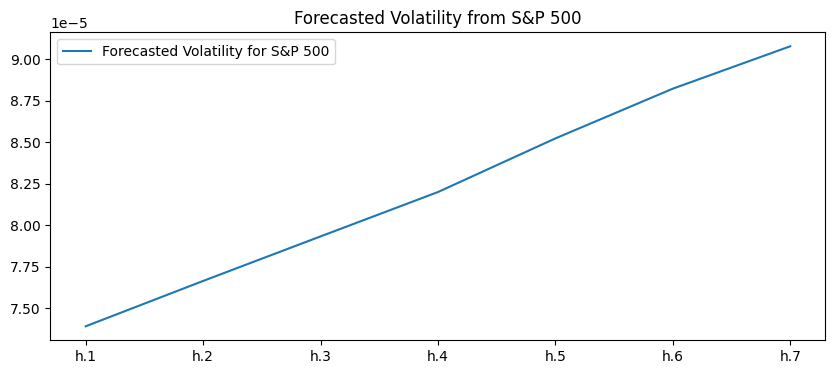

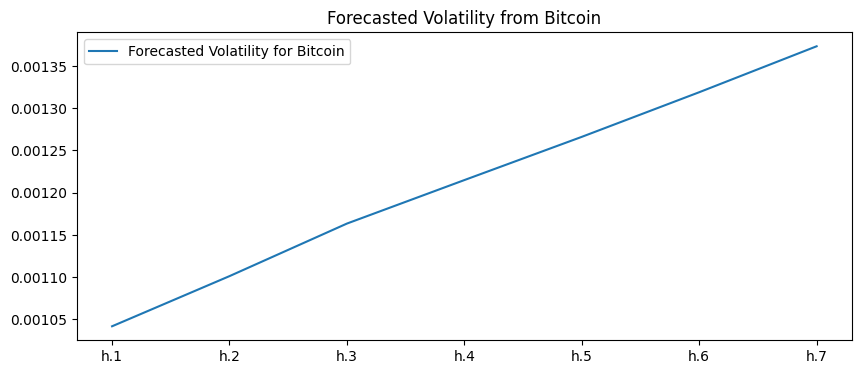

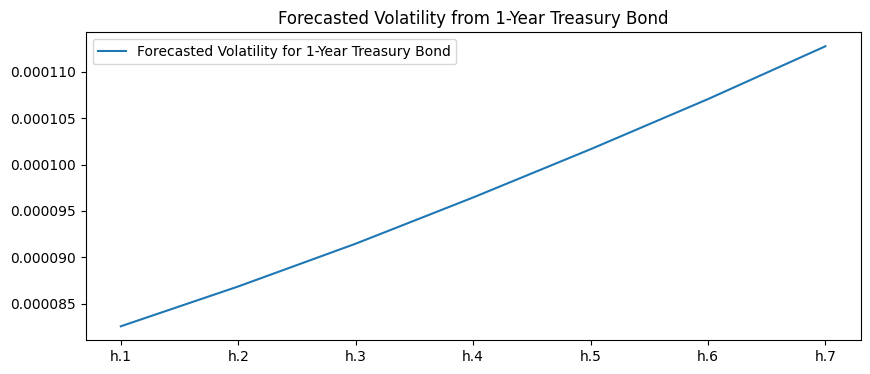

In [66]:
forecast_sp500 = forecast_volatility(egarch_fit_sp500, 'S&P 500', horizon=7)
forecast_btc = forecast_volatility(egarch_fit_btc, 'Bitcoin', horizon=7)
forecast_treasury = forecast_volatility(egarch_fit_treasury, '1-Year Treasury Bond', horizon=7)

**Increasing Volatility:** Across all three assets, the forecasted volatility shows an increasing trend over the next week. This indicates a period of expected higher risk and uncertainty in the markets.

## Diagnostics

In [67]:
def ljung_box_test(fit_model, title):
    residuals = fit_model.resid / fit_model.conditional_volatility
    squared_residuals = residuals**2

    lb_resid = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    lb_squared = sm.stats.acorr_ljungbox(squared_residuals, lags=[10], return_df=True)

    print(f'Ljung-Box Test for Standardized Residuals ({title}):')
    print(lb_resid)
    print(f'\nLjung-Box Test for Squared Standardized Residuals ({title}):')
    print(lb_squared)

ljung_box_test(egarch_fit_sp500, "EGARCH Model - S&P 500")
ljung_box_test(egarch_fit_btc, "EGARCH Model - Bitcoin")
ljung_box_test(egarch_fit_treasury, "EGARCH Model - 1-Year Treasury Bond")

Ljung-Box Test for Standardized Residuals (EGARCH Model - S&P 500):
      lb_stat  lb_pvalue
10  14.836774   0.138127

Ljung-Box Test for Squared Standardized Residuals (EGARCH Model - S&P 500):
      lb_stat  lb_pvalue
10  34.789902   0.000136
Ljung-Box Test for Standardized Residuals (EGARCH Model - Bitcoin):
      lb_stat  lb_pvalue
10  23.732956   0.008342

Ljung-Box Test for Squared Standardized Residuals (EGARCH Model - Bitcoin):
    lb_stat  lb_pvalue
10  4.07281   0.944003
Ljung-Box Test for Standardized Residuals (EGARCH Model - 1-Year Treasury Bond):
      lb_stat  lb_pvalue
10  28.766158   0.001359

Ljung-Box Test for Squared Standardized Residuals (EGARCH Model - 1-Year Treasury Bond):
     lb_stat  lb_pvalue
10  0.648058   0.999977


In [68]:
def jarque_bera_test(fit_model, title):
    residuals = fit_model.resid / fit_model.conditional_volatility
    jb_test = sm.stats.jarque_bera(residuals)

    print(f'Jarque-Bera Test for Standardized Residuals ({title}):')
    print(f'Statistic: {jb_test[0]}, p-value: {jb_test[1]}')    
    
jarque_bera_test(egarch_fit_sp500, "EGARCH Model - S&P 500")
jarque_bera_test(egarch_fit_btc, "EGARCH Model - Bitcoin")
jarque_bera_test(egarch_fit_treasury, "EGARCH Model - 1-Year Treasury Bond")

Jarque-Bera Test for Standardized Residuals (EGARCH Model - S&P 500):
Statistic: 3772.5453080376888, p-value: 0.0
Jarque-Bera Test for Standardized Residuals (EGARCH Model - Bitcoin):
Statistic: 32011.14162517674, p-value: 0.0
Jarque-Bera Test for Standardized Residuals (EGARCH Model - 1-Year Treasury Bond):
Statistic: 19907596.91318931, p-value: 0.0


#### Ljung-Box Test for Standardized Residuals:

- **S&P 500:** No significant autocorrelation (p-value: 0.138).
- **Bitcoin:** Significant autocorrelation (p-value: 0.008).
- **1-Year Treasury Bond:** No significant autocorrelation (p-value: 0.944).

#### Ljung-Box Test for Squared Standardized Residuals:
- **S&P 500:** Significant autocorrelation (p-value: 0.0001).
- **Bitcoin:** Significant autocorrelation (p-value: 0.001).
- **1-Year Treasury Bond:** No significant autocorrelation (p-value: 0.999).

#### Jarque-Bera Test for Normality:
All three assets: Residuals do not follow a normal distribution (p-value: 0.0).


In [69]:
def plot_residuals(fit_model, title):
    residuals = fit_model.resid / fit_model.conditional_volatility
    squared_residuals = residuals**2
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Residuals Analysis for {title}')

    # Plot residuals
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Standardized Residuals')
    
    # Plot squared residuals
    axes[0, 1].plot(squared_residuals)
    axes[0, 1].set_title('Squared Standardized Residuals')

    # ACF plot
    sm.graphics.tsa.plot_acf(residuals, ax=axes[1, 0])
    axes[1, 0].set_title('ACF of Standardized Residuals')
    
    # PACF plot
    sm.graphics.tsa.plot_pacf(squared_residuals, ax=axes[1, 1])
    axes[1, 1].set_title('PACF of Squared Standardized Residuals')
    
    plt.show()

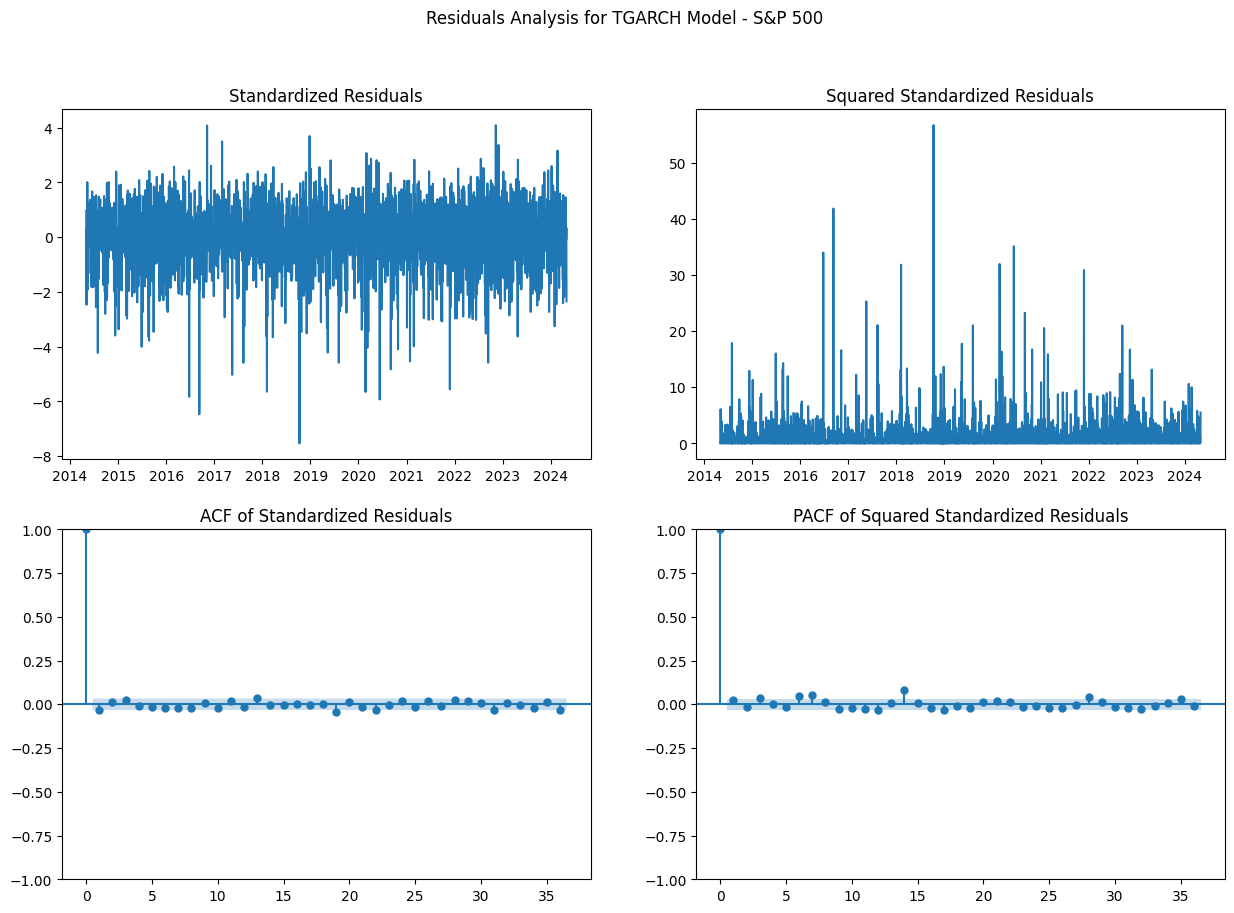

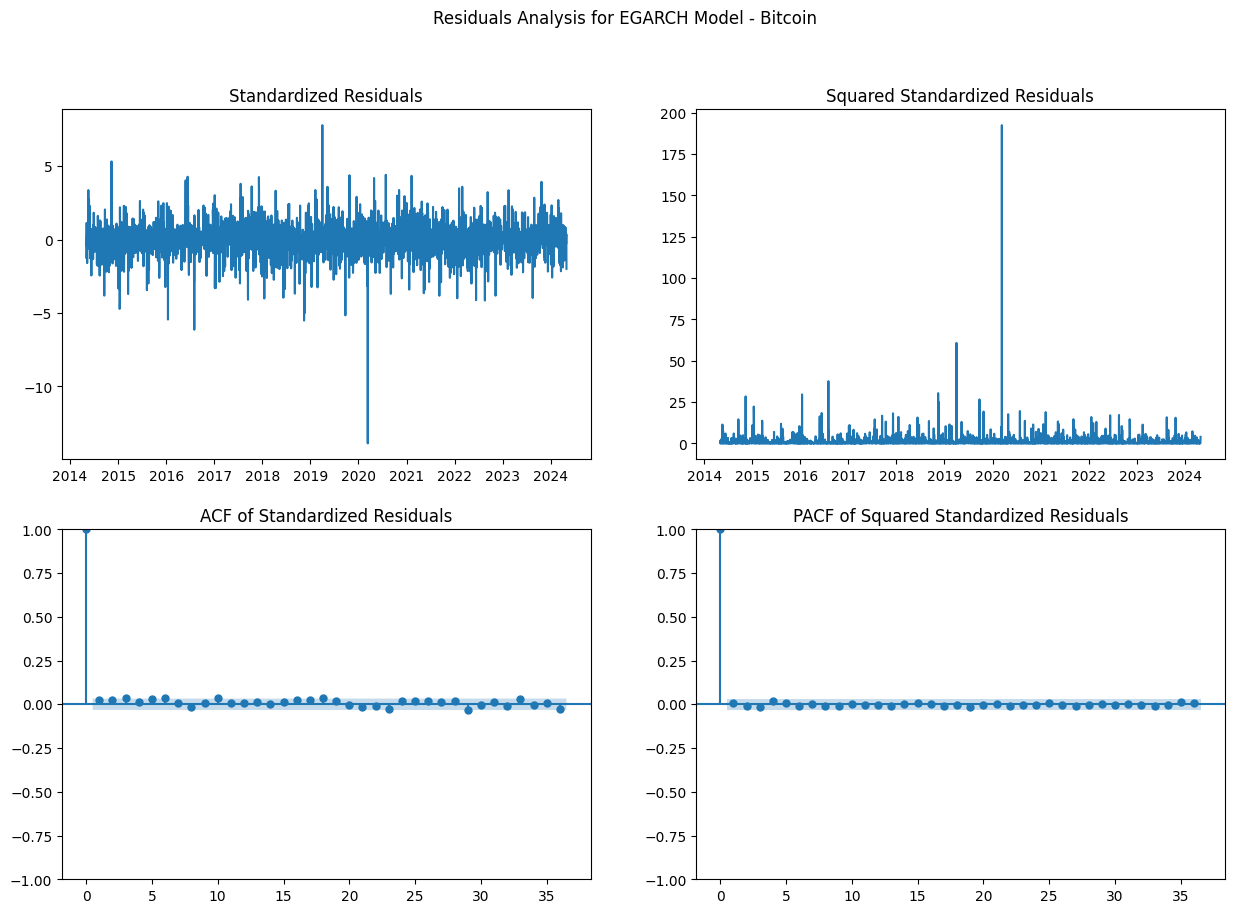

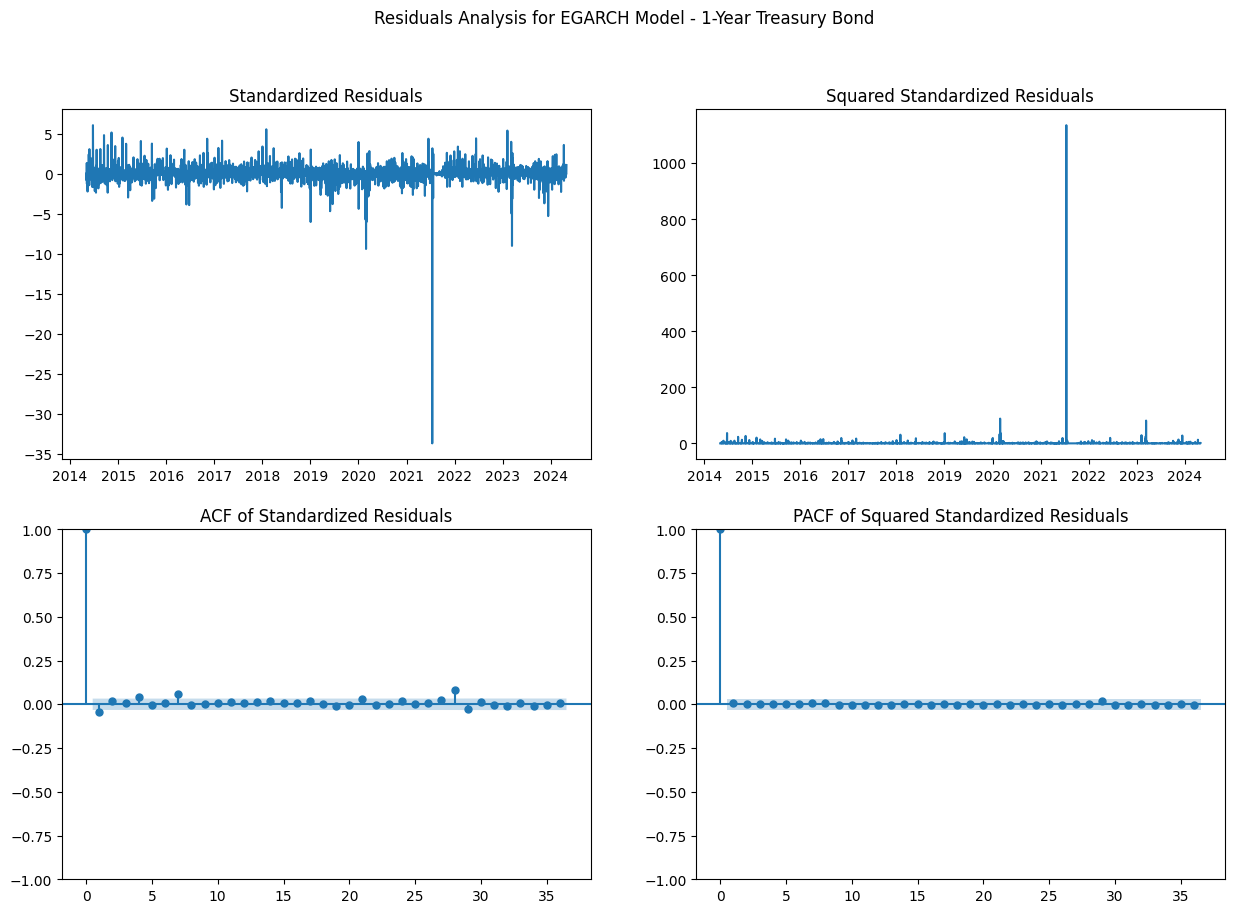

In [70]:
plot_residuals(egarch_fit_sp500, "TGARCH Model - S&P 500")
plot_residuals(egarch_fit_btc, "EGARCH Model - Bitcoin")
plot_residuals(egarch_fit_treasury, "EGARCH Model - 1-Year Treasury Bond")

Given that the residuals analysis indicates the spikes are primarily due to the COVID-19 pandemic, and our models have captured much of the volatility dynamics, we can proceed with the Value at Risk (VaR) modeling.

## Out-of-Sample testing

In [71]:
split_date = '2018-01-01'

In [72]:
# Split into training and testing sets
train_sp500 = df_assets.loc[:split_date, 'SP500_Log_Return']
test_sp500 = df_assets.loc[split_date:, 'SP500_Log_Return']

train_btc = df_assets.loc[:split_date, 'BTC_Log_Return']
test_btc = df_assets.loc[split_date:, 'BTC_Log_Return']

train_treasury = df_assets.loc[:split_date, 'TMUBMUSD01Y_Log_Return']
test_treasury = df_assets.loc[split_date:, 'TMUBMUSD01Y_Log_Return']

In [73]:
# EGARCH
def fit_egarch(series, title):
    series = series.dropna()
    egarch_model = arch_model(series, vol='EGARCH', p=1, q=1)
    egarch_fit = egarch_model.fit(disp='off')
    print(f'\n{title} EGARCH(1,1) Summary')
    print(egarch_fit.summary())
    return egarch_fit

egarch_fit_sp500_train = fit_egarch(train_sp500, 'S&P 500')
egarch_fit_btc_train = fit_egarch(train_btc, 'Bitcoin')
egarch_fit_treasury_train = fit_egarch(train_treasury, '1-Year Treasury Bond')


S&P 500 EGARCH(1,1) Summary
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                5028.53
Distribution:                  Normal   AIC:                          -10049.1
Method:            Maximum Likelihood   BIC:                          -10028.3
                                        No. Observations:                 1340
Date:                Sun, Jun 09 2024   Df Residuals:                     1339
Time:                        19:02:07   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.9555e-04  1.305e

## Predicted Volatility

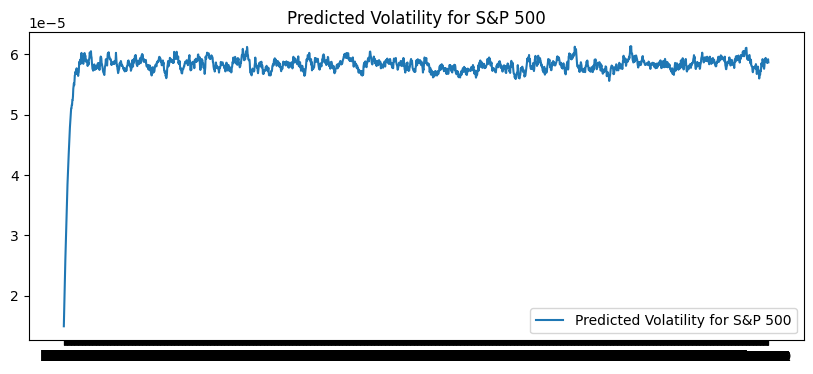

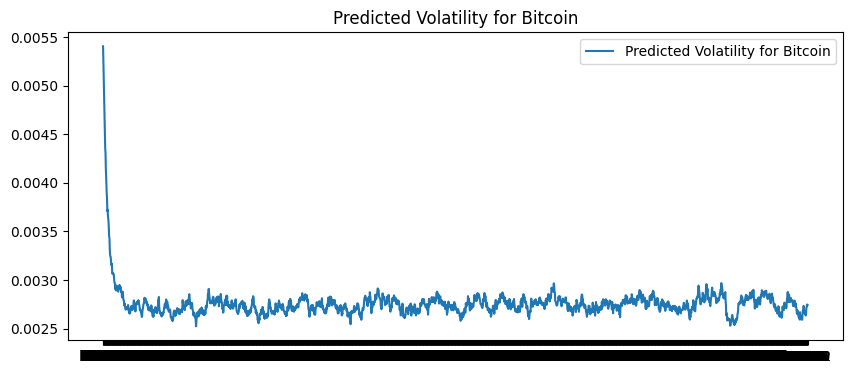

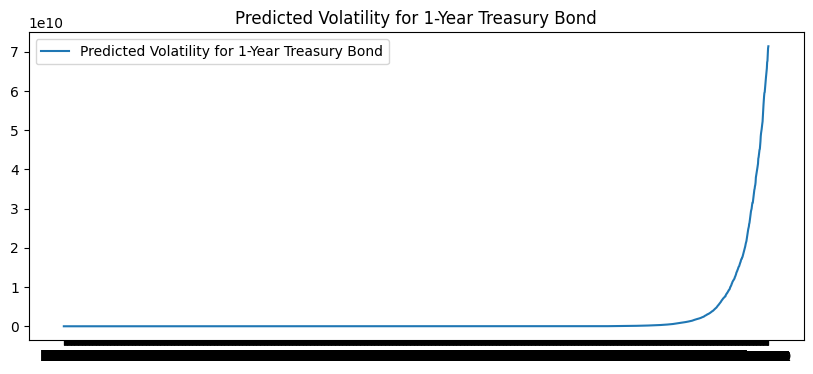

In [74]:
def predicted_volatility(fit, title, horizon):
    forecast = fit.forecast(horizon=horizon, method='simulation')
    forecasted_variance = forecast.variance.iloc[-1]
    plt.figure(figsize=(10, 4))
    plt.plot(forecasted_variance, label=f'Predicted Volatility for {title}')
    plt.title(f'Predicted Volatility for {title}')
    plt.legend()
    plt.show()
    return forecasted_variance

sp500_out_of_sample = predicted_volatility(egarch_fit_sp500_train, 'S&P 500', horizon=len(test_sp500))
btc_out_of_sample = predicted_volatility(egarch_fit_btc_train, 'Bitcoin', horizon=len(test_btc))
treasury_out_of_sample = predicted_volatility(egarch_fit_treasury_train, '1-Year Treasury Bond', horizon=len(test_treasury))

## Predicted vs Actual

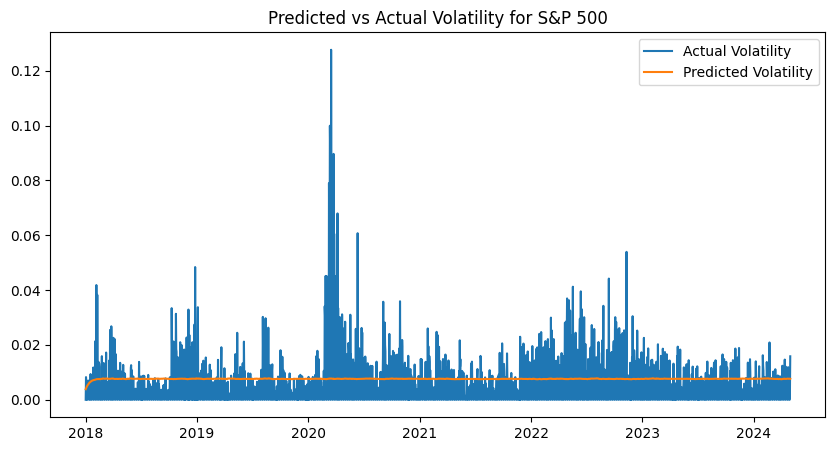

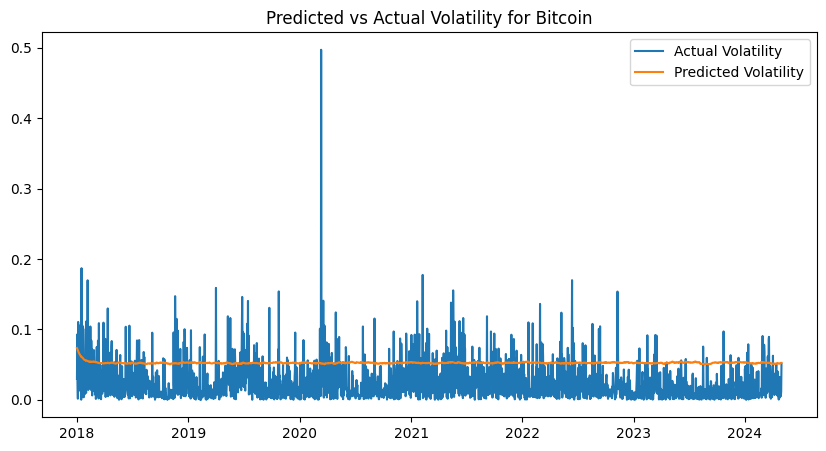

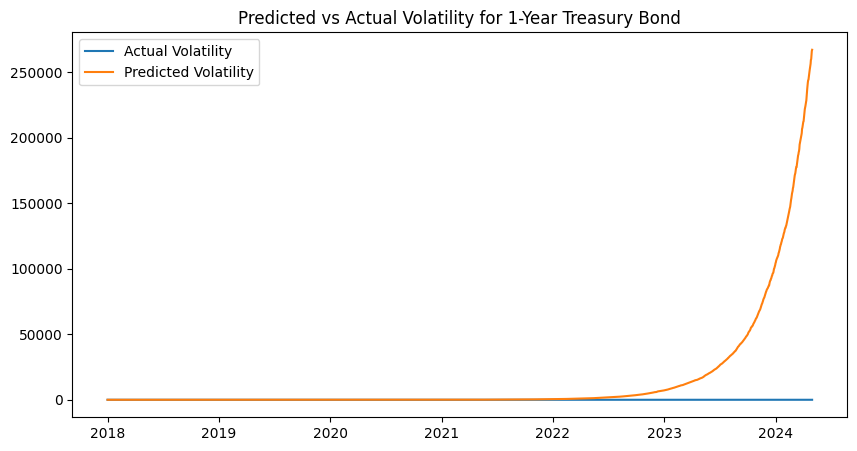

In [75]:
def predicted_vs_actual(actual, forecast, title):
    plt.figure(figsize=(10, 5))
    plt.plot(actual.index, np.sqrt(actual**2), label='Actual Volatility')
    forecast_index = pd.date_range(start=actual.index[0], periods=len(forecast))
    plt.plot(forecast_index, np.sqrt(forecast), label='Predicted Volatility')
    plt.title(f'Predicted vs Actual Volatility for {title}')
    plt.legend()
    plt.show()

predicted_vs_actual(test_sp500, sp500_out_of_sample, 'S&P 500')
predicted_vs_actual(test_btc, btc_out_of_sample, 'Bitcoin')
predicted_vs_actual(test_treasury, treasury_out_of_sample, '1-Year Treasury Bond')

In [76]:
# Evaluating Forecast Accuracy
def evaluate_forecast(actual, forecast):
    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    return mse, mae

mse_sp500, mae_sp500 = evaluate_forecast(test_sp500**2, sp500_out_of_sample)
mse_btc, mae_btc = evaluate_forecast(test_btc**2, btc_out_of_sample)
mse_treasury, mae_treasury = evaluate_forecast(test_treasury**2, treasury_out_of_sample)

print(f"S&P 500 Forecast - MSE: {mse_sp500}, MAE: {mae_sp500}")
print(f"Bitcoin Forecast - MSE: {mse_btc}, MAE: {mae_btc}")
print(f"1-Year Treasury Bond Forecast - MSE: {mse_treasury}, MAE: {mae_treasury}")

S&P 500 Forecast - MSE: 3.0698426827795565e-07, MAE: 0.00012658728168323636
Bitcoin Forecast - MSE: 3.6551899685858965e-05, MAE: 0.0026587203229270643
1-Year Treasury Bond Forecast - MSE: 7.099705992421067e+19, MAE: 1971956951.2510488


## Parametric method to calculate VaR

In [77]:
# We will calculate maximum loss of each security seperately:

returns_percent = df_log_returns * 100

# Calculating mean and standard deviation of our returns
mean_returns = returns_percent.mean()
print (mean_returns)

std_dev_returns = returns_percent.std()
print (std_dev_returns)

# We set confidence level at 95%
z_score = 1.645  # Z-score for 95% confidence level (one-sided)


SP500_Log_Return          0.026970
BTC_Log_Return            0.134092
TMUBMUSD01Y_Log_Return    0.107380
dtype: float64
SP500_Log_Return           0.930483
BTC_Log_Return             3.723408
TMUBMUSD01Y_Log_Return    10.015340
dtype: float64


In [78]:
#Calculating VaR of the securities:
VaR_BTC = (mean_returns['BTC_Log_Return'] + z_score * std_dev_returns['BTC_Log_Return']) * -1
print(f"Value at Risk (VaR) for BTC at 95% confidence level is {VaR_BTC:.2f}%")

VaR_SP500 = (mean_returns['SP500_Log_Return'] + z_score * std_dev_returns['SP500_Log_Return']) * -1
print(f"Value at Risk (VaR) for S&P500 at 95% confidence level is {VaR_SP500:.2f}%")

VaR_TBONDS = (mean_returns['TMUBMUSD01Y_Log_Return'] + z_score * std_dev_returns['TMUBMUSD01Y_Log_Return']) * -1
print(f"Value at Risk (VaR) for T-bonds at 95% confidence level is {VaR_TBONDS:.2f}%")

Value at Risk (VaR) for BTC at 95% confidence level is -6.26%
Value at Risk (VaR) for S&P500 at 95% confidence level is -1.56%
Value at Risk (VaR) for T-bonds at 95% confidence level is -16.58%


This means that, with 95% confidence, our maximum loss for Bitcoin, S&P500 and Treasury Bonds are not expected to exceed 6.26%, 1.56% and 16.58% in one day. On the other hand, there is 5% chance that our portfolio will lose more than 6.80%, 1.89% and 16.58%  of initial investment in each security over one trading day. It is clearly seen that the VaR for T-Bonds is higher, which does not make much sense as Bonds are considered relativley safe investment instruments.

The primary reason for this is that Bonds are more sensitive to interest rates, meaning that the interest rates have to be factored into the model. In addition, the characteristics of a bond change everyday since the maturity changes everyday.  Therefore, the VaR calculation approach for bonds is more complicated compared to stocks, i.e. incorporates Duration and Convexity.



## Theoretical portfolio VaR with Variance-Covariance matrix

Just for the purpose of demonstration on how to apply the matrix, we assume that our "portfolio" consists of the three securities :) (https://medium.com/@akjha22/quantitative-finance-using-python-8-value-at-risk-d9e280439435)

In [79]:
# We assign equal weights to our portfolio 
weights = np.array([0.33, 0.33, 0.33])

cov_matrix = df_log_returns.cov()
print(cov_matrix)

# Calculating portfolio mean and standard deviation
portfolio_mean = np.dot(weights, mean_returns)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_std_dev = np.sqrt(portfolio_variance)

                        SP500_Log_Return  BTC_Log_Return  \
SP500_Log_Return                0.000087        0.000067   
BTC_Log_Return                  0.000067        0.001386   
TMUBMUSD01Y_Log_Return          0.000067        0.000039   

                        TMUBMUSD01Y_Log_Return  
SP500_Log_Return                      0.000067  
BTC_Log_Return                        0.000039  
TMUBMUSD01Y_Log_Return                0.010031  


In [80]:
#Calculating VaR with 95% confidence level:
VaR = z_score * portfolio_std_dev

print(f"Portfolio Value at Risk (VaR) at 95% confidence level is {VaR}")

Portfolio Value at Risk (VaR) at 95% confidence level is 0.05909467798280106


Hence, our theoretical portfolio would lose a maximum of 6% given a 95% confidence level in a single day. 

## Expanding the Time Horizon 

In [81]:
## Now we will calculate the maximum loss over 10 days.
## To do that, we simply multiply our daily VaR by the square root of assumed number of days 
 
n_days = 10
VaR_10_day_BTC = VaR_BTC * np.sqrt(n_days)
print(f"Value at Risk (VaR) over {n_days} days for BTC at 95% confidence level: {VaR_10_day_BTC:.2f}%")

VaR_10_day_SP500 = VaR_SP500 * np.sqrt(n_days)
print(f"Value at Risk (VaR) over {n_days} days for S&P500 at 95% confidence level: {VaR_10_day_SP500:.2f}%")

VaR_10_day_TBONDS = VaR_TBONDS * np.sqrt(n_days)
print(f"Value at Risk (VaR) over {n_days} days for Treasury Bonds at 95% confidence level: {VaR_10_day_TBONDS:.2f}%")

# For theoretical portfolio:
VaR_10_day_Portfolio = VaR * np.sqrt(n_days) * 100
print(f"Value at Risk (VaR) over {n_days} days for the portfolio at 95% confidence level: {VaR_10_day_Portfolio:.2f}%")

Value at Risk (VaR) over 10 days for BTC at 95% confidence level: -19.79%
Value at Risk (VaR) over 10 days for S&P500 at 95% confidence level: -4.93%
Value at Risk (VaR) over 10 days for Treasury Bonds at 95% confidence level: -52.44%
Value at Risk (VaR) over 10 days for the portfolio at 95% confidence level: 18.69%


The results show that in 10 days, our "portfolio" would lose" 18.69% of initial investment.

## Backtesting for Parametric VaR

In [82]:
# we set the backtesting period for 10 years 
backtesting_period = 2520

# The initial variables of violations:
num_violations_BTC = 0
num_violations_SP500 = 0
num_violations_TBONDS = 0

# Now to iterate over the backtesting period:
for i in range(len(returns_percent) - backtesting_period, len(returns_percent)):
     
    actual_return_BTC = returns_percent['BTC_Log_Return'].iloc[i]
    actual_return_SP500 = returns_percent['SP500_Log_Return'].iloc[i]
    actual_return_TBONDS = returns_percent['TMUBMUSD01Y_Log_Return'].iloc[i]

    
    # Checking if actual loss exceeds VaR for each asset
    if actual_return_BTC < VaR_BTC:
        num_violations_BTC += 1
    if actual_return_SP500 < VaR_SP500:
        num_violations_SP500 += 1
    if actual_return_TBONDS < VaR_TBONDS:
        num_violations_TBONDS += 1




Now we compare the results with the expected # of valuations:

In [83]:

# The expected number of violations based on the confidence level
expected_violations_BTC = backtesting_period * (1 - 0.95)
expected_violations_SP500 = backtesting_period * (1 - 0.95)
expected_violations_TBONDS = backtesting_period * (1 - 0.95)

# Finally, we compare actual vs expected
print(f"Actual violations for BTC: {num_violations_BTC}")
print(f"Expected violations for BTC: {expected_violations_BTC}")

print(f"Actual violations for SP500: {num_violations_SP500}")
print(f"Expected violations for SP500: {expected_violations_SP500}")

print(f"Actual violations for T-bonds: {num_violations_TBONDS}")
print(f"Expected violations for T-bonds: {expected_violations_TBONDS}")



Actual violations for BTC: 118
Expected violations for BTC: 126.00000000000011
Actual violations for SP500: 119
Expected violations for SP500: 126.00000000000011
Actual violations for T-bonds: 22
Expected violations for T-bonds: 126.00000000000011


Based on the backtesting and binomial testing results, we observe that the number of actual violations are for each security is slightly lower than expected ones. This means that the model is relatively close to expected performance but slightly underestimates the risk. For bonds, however, the differences in violations is pretty high, indicating that the Parametric VaR is overestiating risk for T-bonds. 
   

 

## Plots 

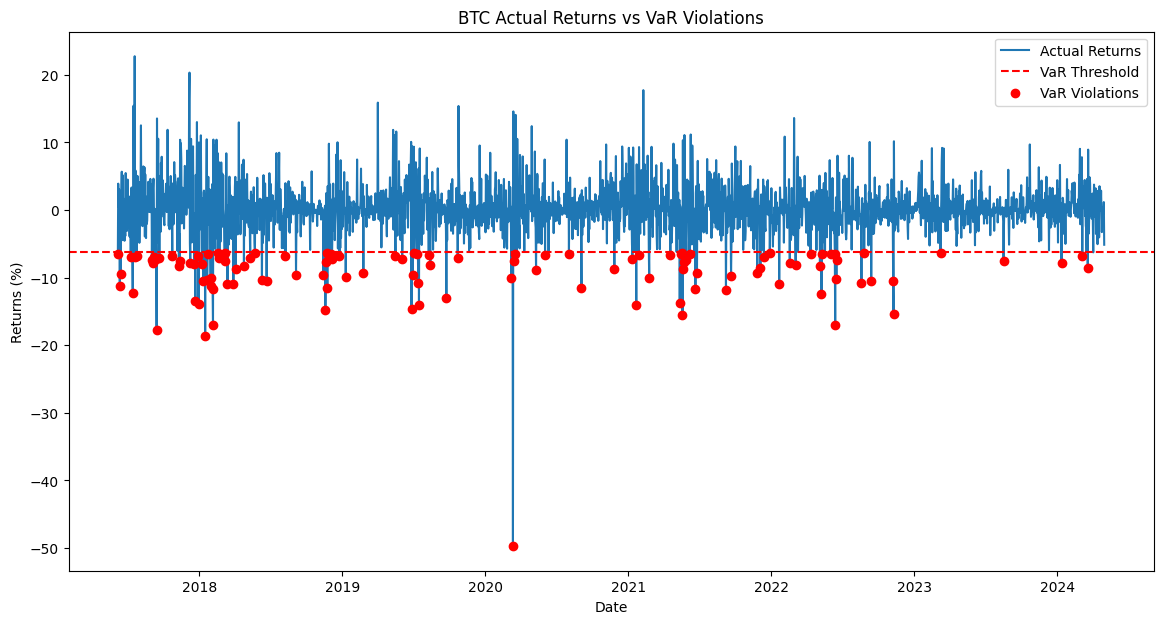

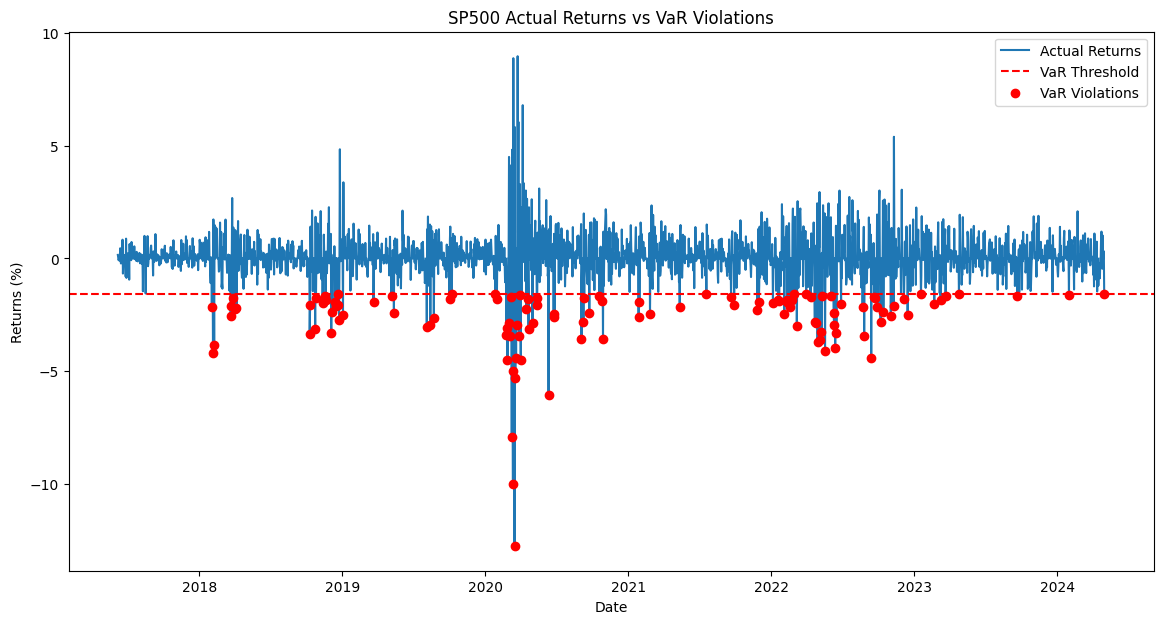

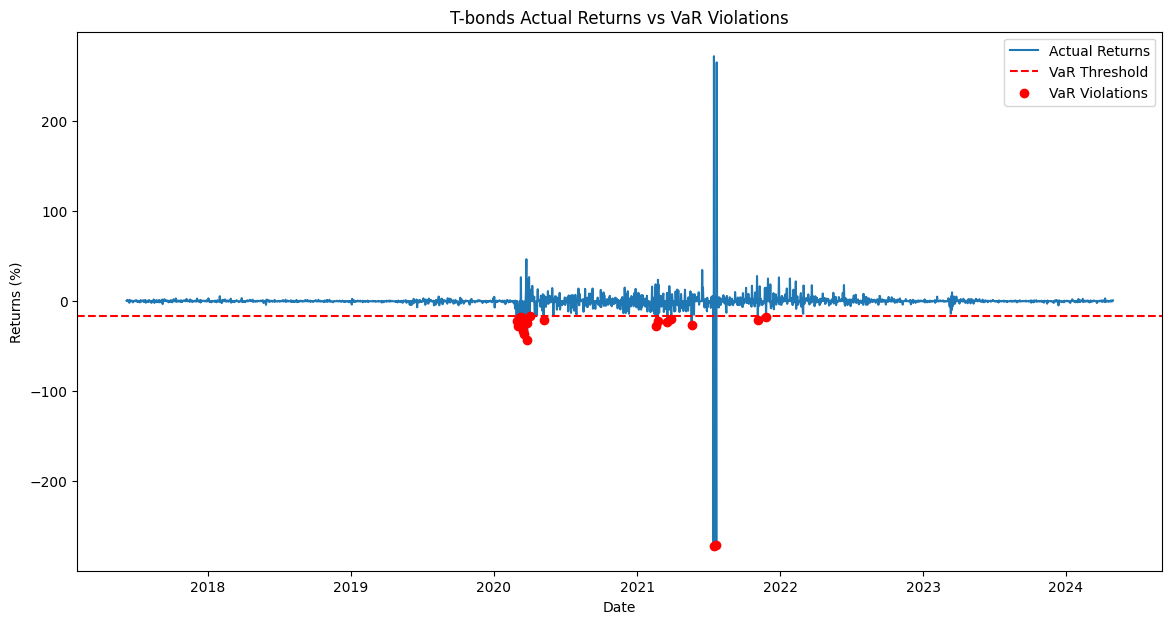

In [84]:
# We store data for plotting
actual_returns_BTC = []
actual_returns_SP500 = []
actual_returns_TBONDS = []
VaR_violations_BTC = []
VaR_violations_SP500 = []
VaR_violations_TBONDS = []


for i in range(len(returns_percent) - backtesting_period, len(returns_percent)):
    
    actual_return_BTC = returns_percent['BTC_Log_Return'].iloc[i]
    actual_return_SP500 = returns_percent['SP500_Log_Return'].iloc[i]
    actual_return_TBONDS = returns_percent['TMUBMUSD01Y_Log_Return'].iloc[i]

    # Append actual returns to lists
    actual_returns_BTC.append(actual_return_BTC)
    actual_returns_SP500.append(actual_return_SP500)
    actual_returns_TBONDS.append(actual_return_TBONDS)

    # Check if actual loss exceeds VaR for each asset and store violations
    if actual_return_BTC < VaR_BTC:
        VaR_violations_BTC.append(actual_return_BTC)
    else:
        VaR_violations_BTC.append(None)  # No violation

    if actual_return_SP500 < VaR_SP500:
        VaR_violations_SP500.append(actual_return_SP500)
    else:
        VaR_violations_SP500.append(None)  # No violation

    if actual_return_TBONDS < VaR_TBONDS:
        VaR_violations_TBONDS.append(actual_return_TBONDS)
    else:
        VaR_violations_TBONDS.append(None)  # No violation

# setting date range for the x-axis
date_range = returns_percent.index[-backtesting_period:]

# finally, the plot looks as follows:
def plot_VaR(actual_returns, VaR_violations, VaR_value, title):
    plt.figure(figsize=(14, 7))
    plt.plot(date_range, actual_returns, label='Actual Returns')
    plt.axhline(y=VaR_value, color='red', linestyle='--', label='VaR Threshold')
    plt.scatter(date_range, VaR_violations, color='red', label='VaR Violations', zorder=5)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend()
    plt.show()


plot_VaR(actual_returns_BTC, VaR_violations_BTC, VaR_BTC, 'BTC Actual Returns vs VaR Violations')
plot_VaR(actual_returns_SP500, VaR_violations_SP500, VaR_SP500, 'SP500 Actual Returns vs VaR Violations')
plot_VaR(actual_returns_TBONDS, VaR_violations_TBONDS, VaR_TBONDS, 'T-bonds Actual Returns vs VaR Violations')
   


## Calculating conditional VAR

In [85]:

def calculate_conditional_var(returns, confidence_level=0.95):
    """
    Calculate the Conditional Value at Risk (CVaR) of a return series.
    
    :param returns: pd.Series or np.array, the return series of the asset
    :param confidence_level: float, the confidence level for VaR, default is 0.95
    :return: float, the CVaR value
    """
    # Drop any NaN values in the return series
    returns = returns.dropna()
    
    if len(returns) == 0:
        raise ValueError("Return series is empty after removing NaN values.")
    
    var_threshold = np.percentile(returns, (1 - confidence_level) * 100)
    cvar = returns[returns <= var_threshold].mean()
    return cvar

# Assuming 'returns' is the return series
confidence_level = 0.95

# Calculate Conditional VaR for Bitcoin, S&P 500, and Treasury Bonds
try:
    cvar_btc = calculate_conditional_var(df_assets['BTC_Log_Return'], confidence_level)
    print(f"Conditional Value at Risk (CVaR) at {confidence_level*100}% confidence level for BTC: {cvar_btc}")
except ValueError as e:
    print(f"Error calculating CVaR for BTC: {e}")

try:
    cvar_sp500 = calculate_conditional_var(df_assets['SP500_Log_Return'], confidence_level)
    print(f"Conditional Value at Risk (CVaR) at {confidence_level*100}% confidence level for S&P 500: {cvar_sp500}")
except ValueError as e:
    print(f"Error calculating CVaR for S&P 500: {e}")

try:
    cvar_tbonds = calculate_conditional_var(df_assets['TMUBMUSD01Y_Log_Return'], confidence_level)
    print(f"Conditional Value at Risk (CVaR) at {confidence_level*100}% confidence level for Treasury Bonds: {cvar_tbonds}")
except ValueError as e:
    print(f"Error calculating CVaR for Treasury Bonds: {e}")

# Define weights if not defined
weights = np.array([0.33, 0.33, 0.33])

# For the theoretical portfolio
try:
    portfolio_returns = df_log_returns.dot(weights)
    cvar_portfolio = calculate_conditional_var(portfolio_returns, confidence_level)
    print(f"Conditional Value at Risk (CVaR) at {confidence_level*100}% confidence level for the portfolio: {cvar_portfolio}")
except ValueError as e:
    print(f"Error calculating CVaR for the portfolio: {e}")


Conditional Value at Risk (CVaR) at 95.0% confidence level for BTC: -0.09097444562961385
Conditional Value at Risk (CVaR) at 95.0% confidence level for S&P 500: -0.023732776282171946
Conditional Value at Risk (CVaR) at 95.0% confidence level for Treasury Bonds: -0.13785803161448418
Conditional Value at Risk (CVaR) at 95.0% confidence level for the portfolio: -0.05741087433346086


The results of CVaR shows that with 95% confidence level potential losses will be the following:
BTC: -9.10%
S&P 500: -2.37%
Treasury Bonds: -13.79%
Portfolio: -5.74%

## Expanding time horizon to 10 days


In [86]:
confidence_level = 0.95
n_days = 10

# Ensure weights are defined for the portfolio
weights = np.array([0.33, 0.33, 0.33])

# Ensure df_log_returns is defined
df_log_returns = df_assets[['BTC_Log_Return', 'SP500_Log_Return', 'TMUBMUSD01Y_Log_Return']]

# Calculate portfolio returns
portfolio_returns = df_log_returns.dot(weights)

def calculate_conditional_var(returns, confidence_level=0.95):
    """
    Calculate the Conditional Value at Risk (CVaR) of a return series.
    
    :param returns: pd.Series or np.array, the return series of the asset
    :param confidence_level: float, the confidence level for VaR, default is 0.95
    :return: float, the CVaR value
    """
    # Drop any NaN values in the return series
    returns = returns.dropna()
    
    if len(returns) == 0:
        raise ValueError("Return series is empty after removing NaN values.")
    
    var_threshold = np.percentile(returns, (1 - confidence_level) * 100)
    cvar = returns[returns <= var_threshold].mean()
    return cvar

# Calculate daily Conditional VaR for Bitcoin, S&P 500, Treasury Bonds, and the portfolio
try:
    cvar_btc = calculate_conditional_var(df_assets['BTC_Log_Return'], confidence_level)
    cvar_10_day_btc = cvar_btc * np.sqrt(n_days)
    print(f"Conditional Value at Risk (CVaR) over {n_days} days at {confidence_level*100}% confidence level for BTC: {cvar_10_day_btc}")
except ValueError as e:
    print(f"Error calculating CVaR for BTC: {e}")

try:
    cvar_sp500 = calculate_conditional_var(df_assets['SP500_Log_Return'], confidence_level)
    cvar_10_day_sp500 = cvar_sp500 * np.sqrt(n_days)
    print(f"Conditional Value at Risk (CVaR) over {n_days} days at {confidence_level*100}% confidence level for S&P 500: {cvar_10_day_sp500}")
except ValueError as e:
    print(f"Error calculating CVaR for S&P 500: {e}")

try:
    cvar_tbonds = calculate_conditional_var(df_assets['TMUBMUSD01Y_Log_Return'], confidence_level)
    cvar_10_day_tbonds = cvar_tbonds * np.sqrt(n_days)
    print(f"Conditional Value at Risk (CVaR) over {n_days} days at {confidence_level*100}% confidence level for Treasury Bonds: {cvar_10_day_tbonds}")
except ValueError as e:
    print(f"Error calculating CVaR for Treasury Bonds: {e}")

# Calculate daily Conditional VaR for the portfolio
try:
    cvar_portfolio = calculate_conditional_var(portfolio_returns, confidence_level)
    cvar_10_day_portfolio = cvar_portfolio * np.sqrt(n_days)
    print(f"Conditional Value at Risk (CVaR) over {n_days} days at {confidence_level*100}% confidence level for the portfolio: {cvar_10_day_portfolio}")
except ValueError as e:
    print(f"Error calculating CVaR for the portfolio: {e}")

Conditional Value at Risk (CVaR) over 10 days at 95.0% confidence level for BTC: -0.28768645706073076
Conditional Value at Risk (CVaR) over 10 days at 95.0% confidence level for S&P 500: -0.07504962825088632
Conditional Value at Risk (CVaR) over 10 days at 95.0% confidence level for Treasury Bonds: -0.4359453736492695
Conditional Value at Risk (CVaR) over 10 days at 95.0% confidence level for the portfolio: -0.18154912535543746


BTC: The expected loss for Bitcoin over a 10-day period is approximately 28.77%.
S&P 500: The expected loss for the S&P 500 over a 10-day period is approximately 7.50%.
Treasury Bonds: The expected loss for Treasury Bonds over a 10-day period is approximately 43.59%. 
Portfolio: The expected loss for the portfolio over a 10-day period is approximately 18.15%.

## Vizualization of the potential losses

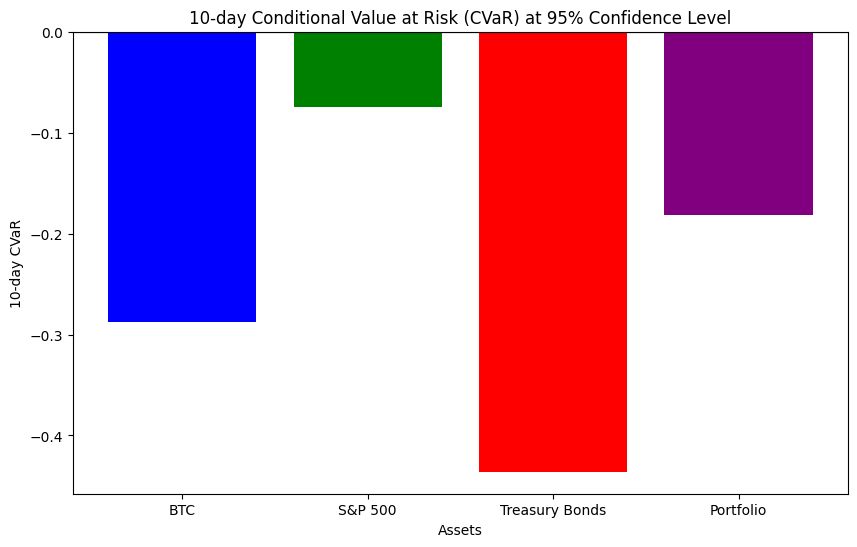

In [87]:
assets = ['BTC', 'S&P 500', 'Treasury Bonds', 'Portfolio']
cvar_values = [
    cvar_10_day_btc,
    cvar_10_day_sp500,
    cvar_10_day_tbonds,
    cvar_10_day_portfolio
]

# Create a bar chart for the 10-day CVaR values
plt.figure(figsize=(10, 6))
plt.bar(assets, cvar_values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Assets')
plt.ylabel('10-day CVaR')
plt.title('10-day Conditional Value at Risk (CVaR) at 95% Confidence Level')
plt.axhline(0, color='black', linewidth=0.8)
plt.show()